In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.datasets import daocensus_text
import src.utils.notebooks as nbutils

sns.set_theme()
plt.rcParams['figure.dpi'] = 600

In [2]:
# 'ORG_NAME', 'ORG_PLATFORM', 'SPLITS_FREQ', 'SPLITS_NORMALIZE', 'LAST_SPLITS', 'USE_ORG_NAMES'

ORG_NAME = 'Aave - Aavegotchi'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES = True

# Not used
SPLITS_FREQ = ...
SPLITS_NORMALIZE = ...
LAST_SPLITS = ...

In [3]:
# Parameters
ORG_NAME = "DEAD FoundationsDAO"
ORG_PLATFORM = "daohaus"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 12s:00"


In [4]:
dfv, dfp = daocensus_text.get('./data/daos-census-text', ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 17738 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17738 entries, 0 to 17737
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       17738 non-null  object        
 1   name           17738 non-null  object        
 2   id             17738 non-null  object        
 3   proposal       17738 non-null  category      
 4   deployment     17738 non-null  object        
 5   platform_vote  17738 non-null  object        
 6   voter          17738 non-null  category      
 7   date           17738 non-null  datetime64[ns]
 8   choice         17738 non-null  object        
 9   weight         17738 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 5591 entries, 9b0951e8-192b-5b68-8e1a-1b392e5b704f to eb70c717-6190-50a9-9a3d-aab41a843

# Exploración de datos de Decentraland

In [5]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

DEAD FoundationsDAO tiene 17738 votos de 3469 voters en 5591 propuestas


In [6]:
dfd = dfp[['platform', 'name', 'platform_deployment']].drop_duplicates()
dfd

platform                 name  \
id                                                                   
9b0951e8-192b-5b68-8e1a-1b392e5b704f  daohaus  DEAD FoundationsDAO   

                                                             platform_deployment  
id                                                                                
9b0951e8-192b-5b68-8e1a-1b392e5b704f  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8

## Histograma de votos por usuario

3469
8
count    3469.000000
mean        5.113289
std        70.003581
min         1.000000
50%         3.000000
90%         5.000000
95%         7.000000
99%        15.000000
max      4020.000000
dtype: float64


Cannot show ipywidgets in text

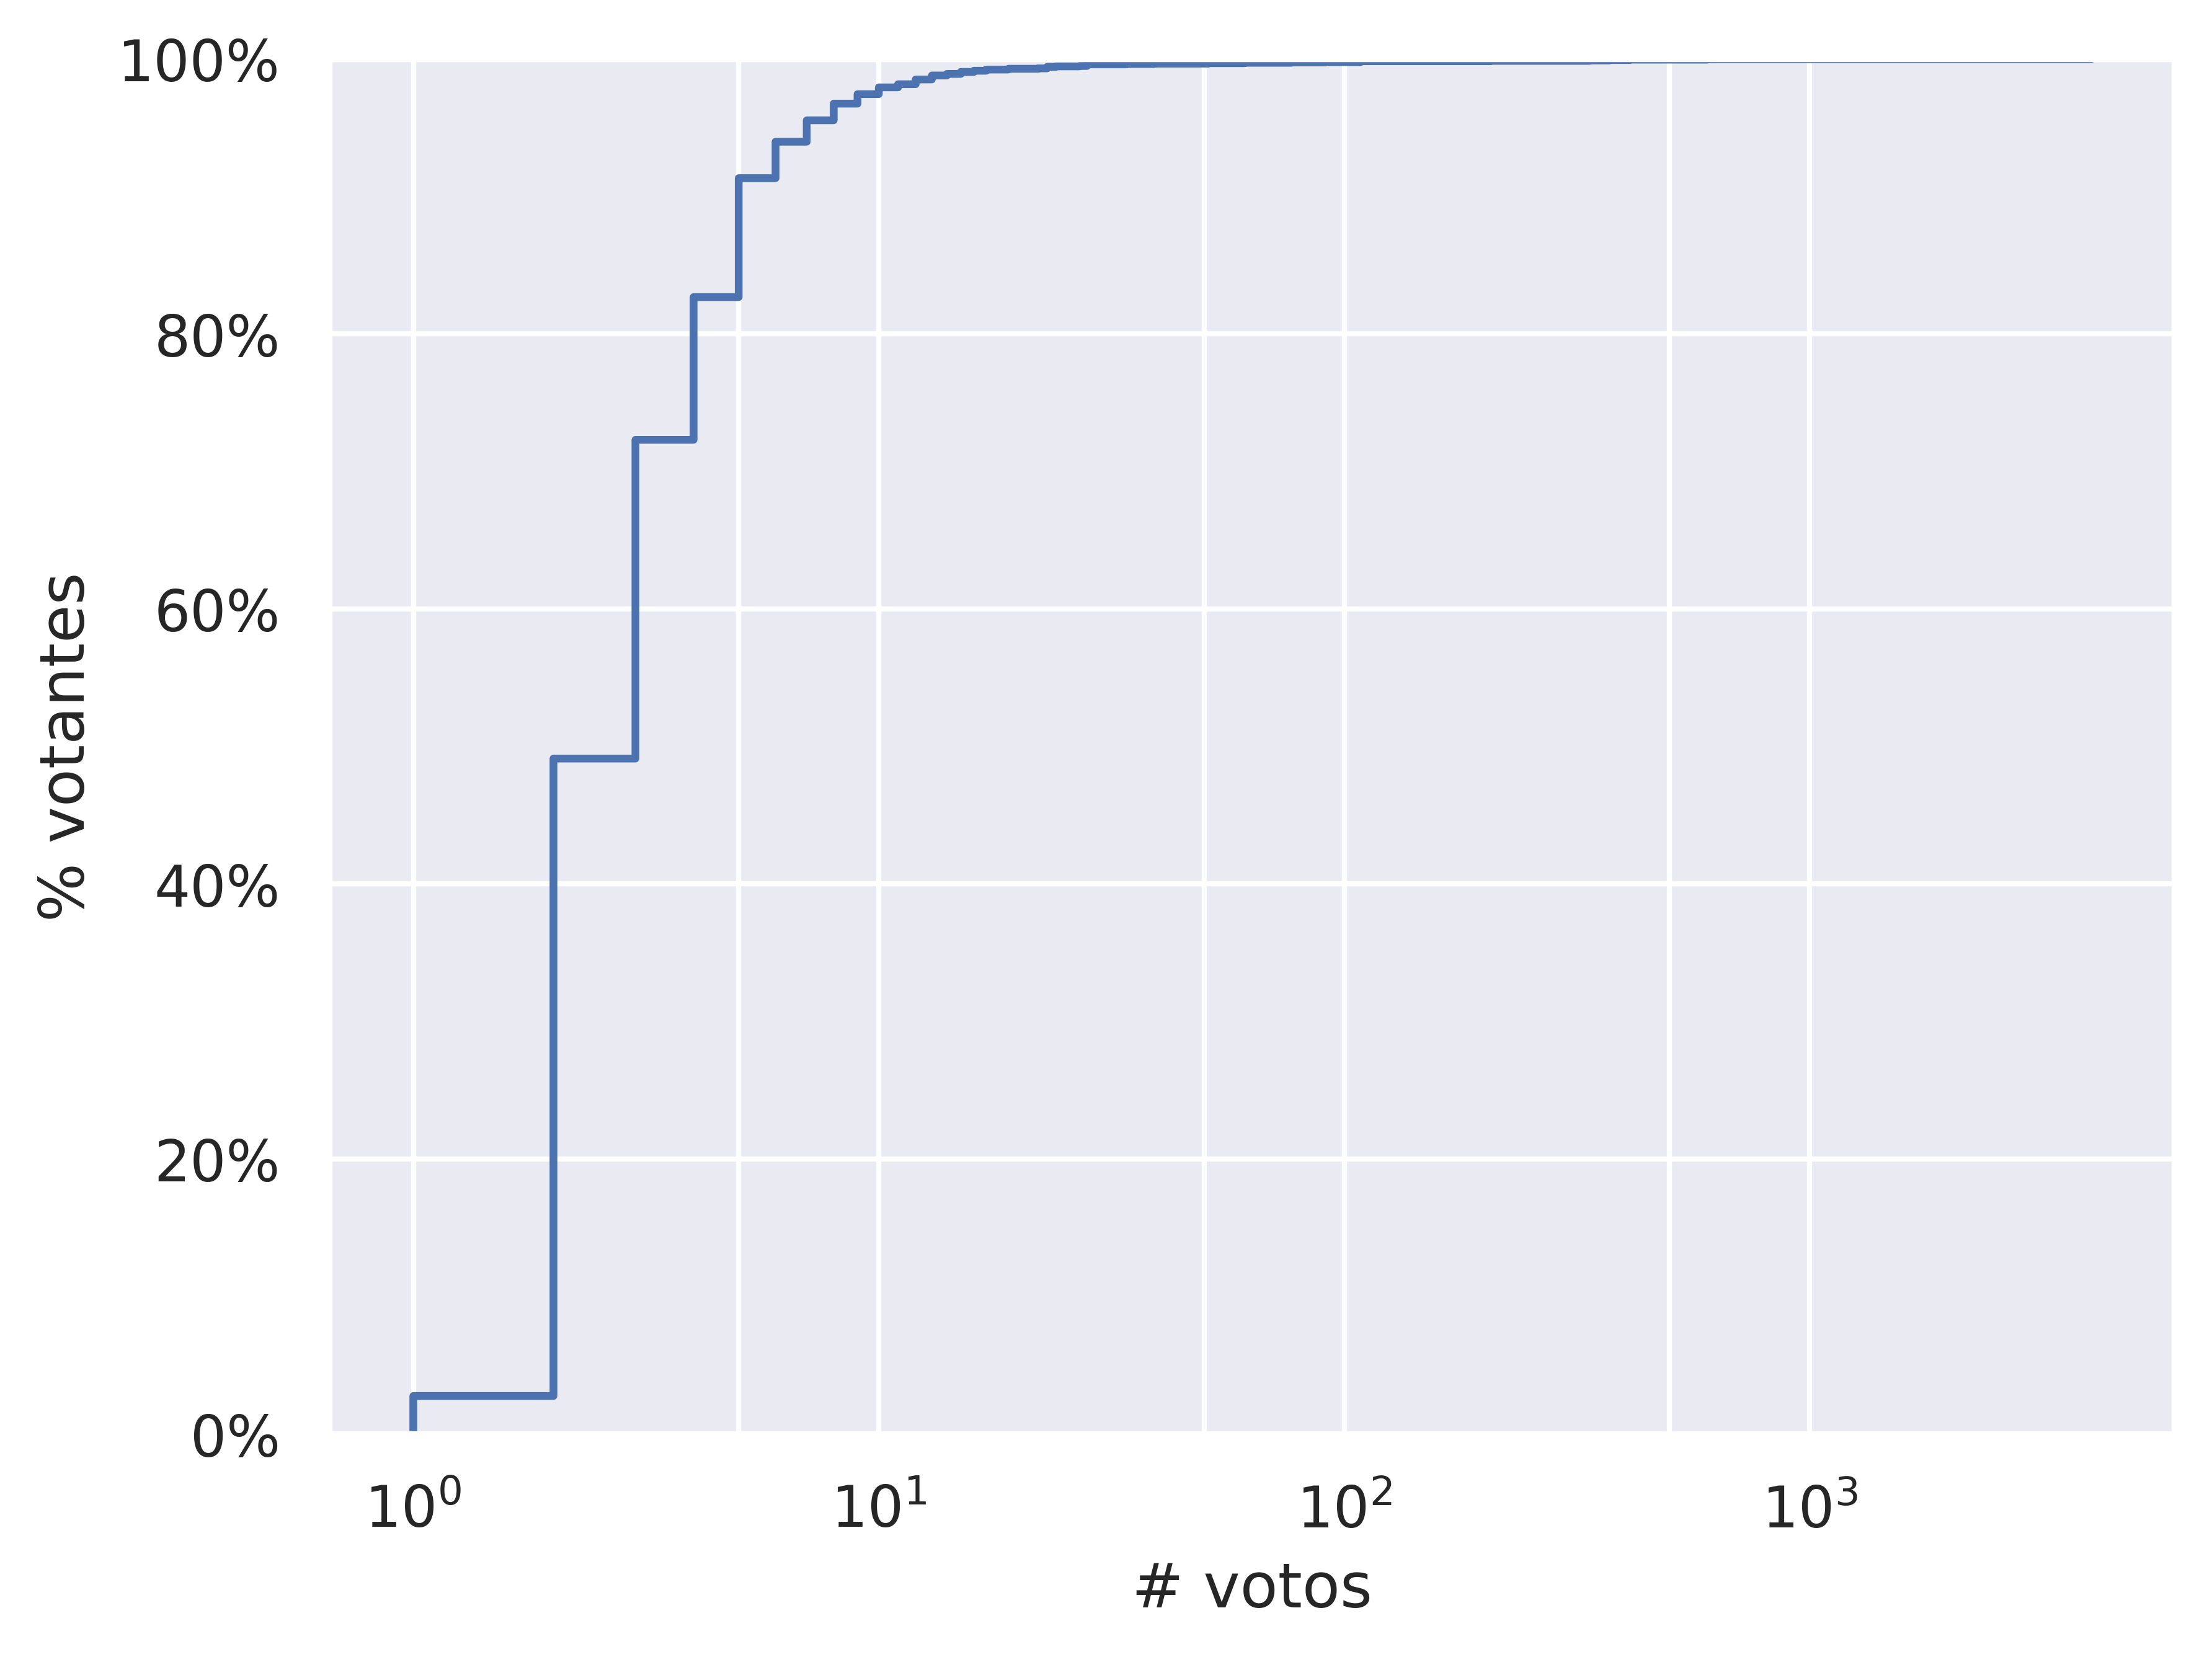

In [7]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print( len(_toplot) )
print( (_toplot > 100).sum() )
print(_toplot.describe(percentiles=[.5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votos')
plt.ylabel('% votantes')

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_voters_{ORG_NAME}.pdf')

## Histograma de votos por propuesta

count    5591.000000
mean        3.172599
std         5.710431
min         1.000000
50%         2.000000
75%         3.000000
90%         6.000000
95%         9.000000
99%        21.000000
max       120.000000
Name: votes_count, dtype: float64
0


Cannot show ipywidgets in text

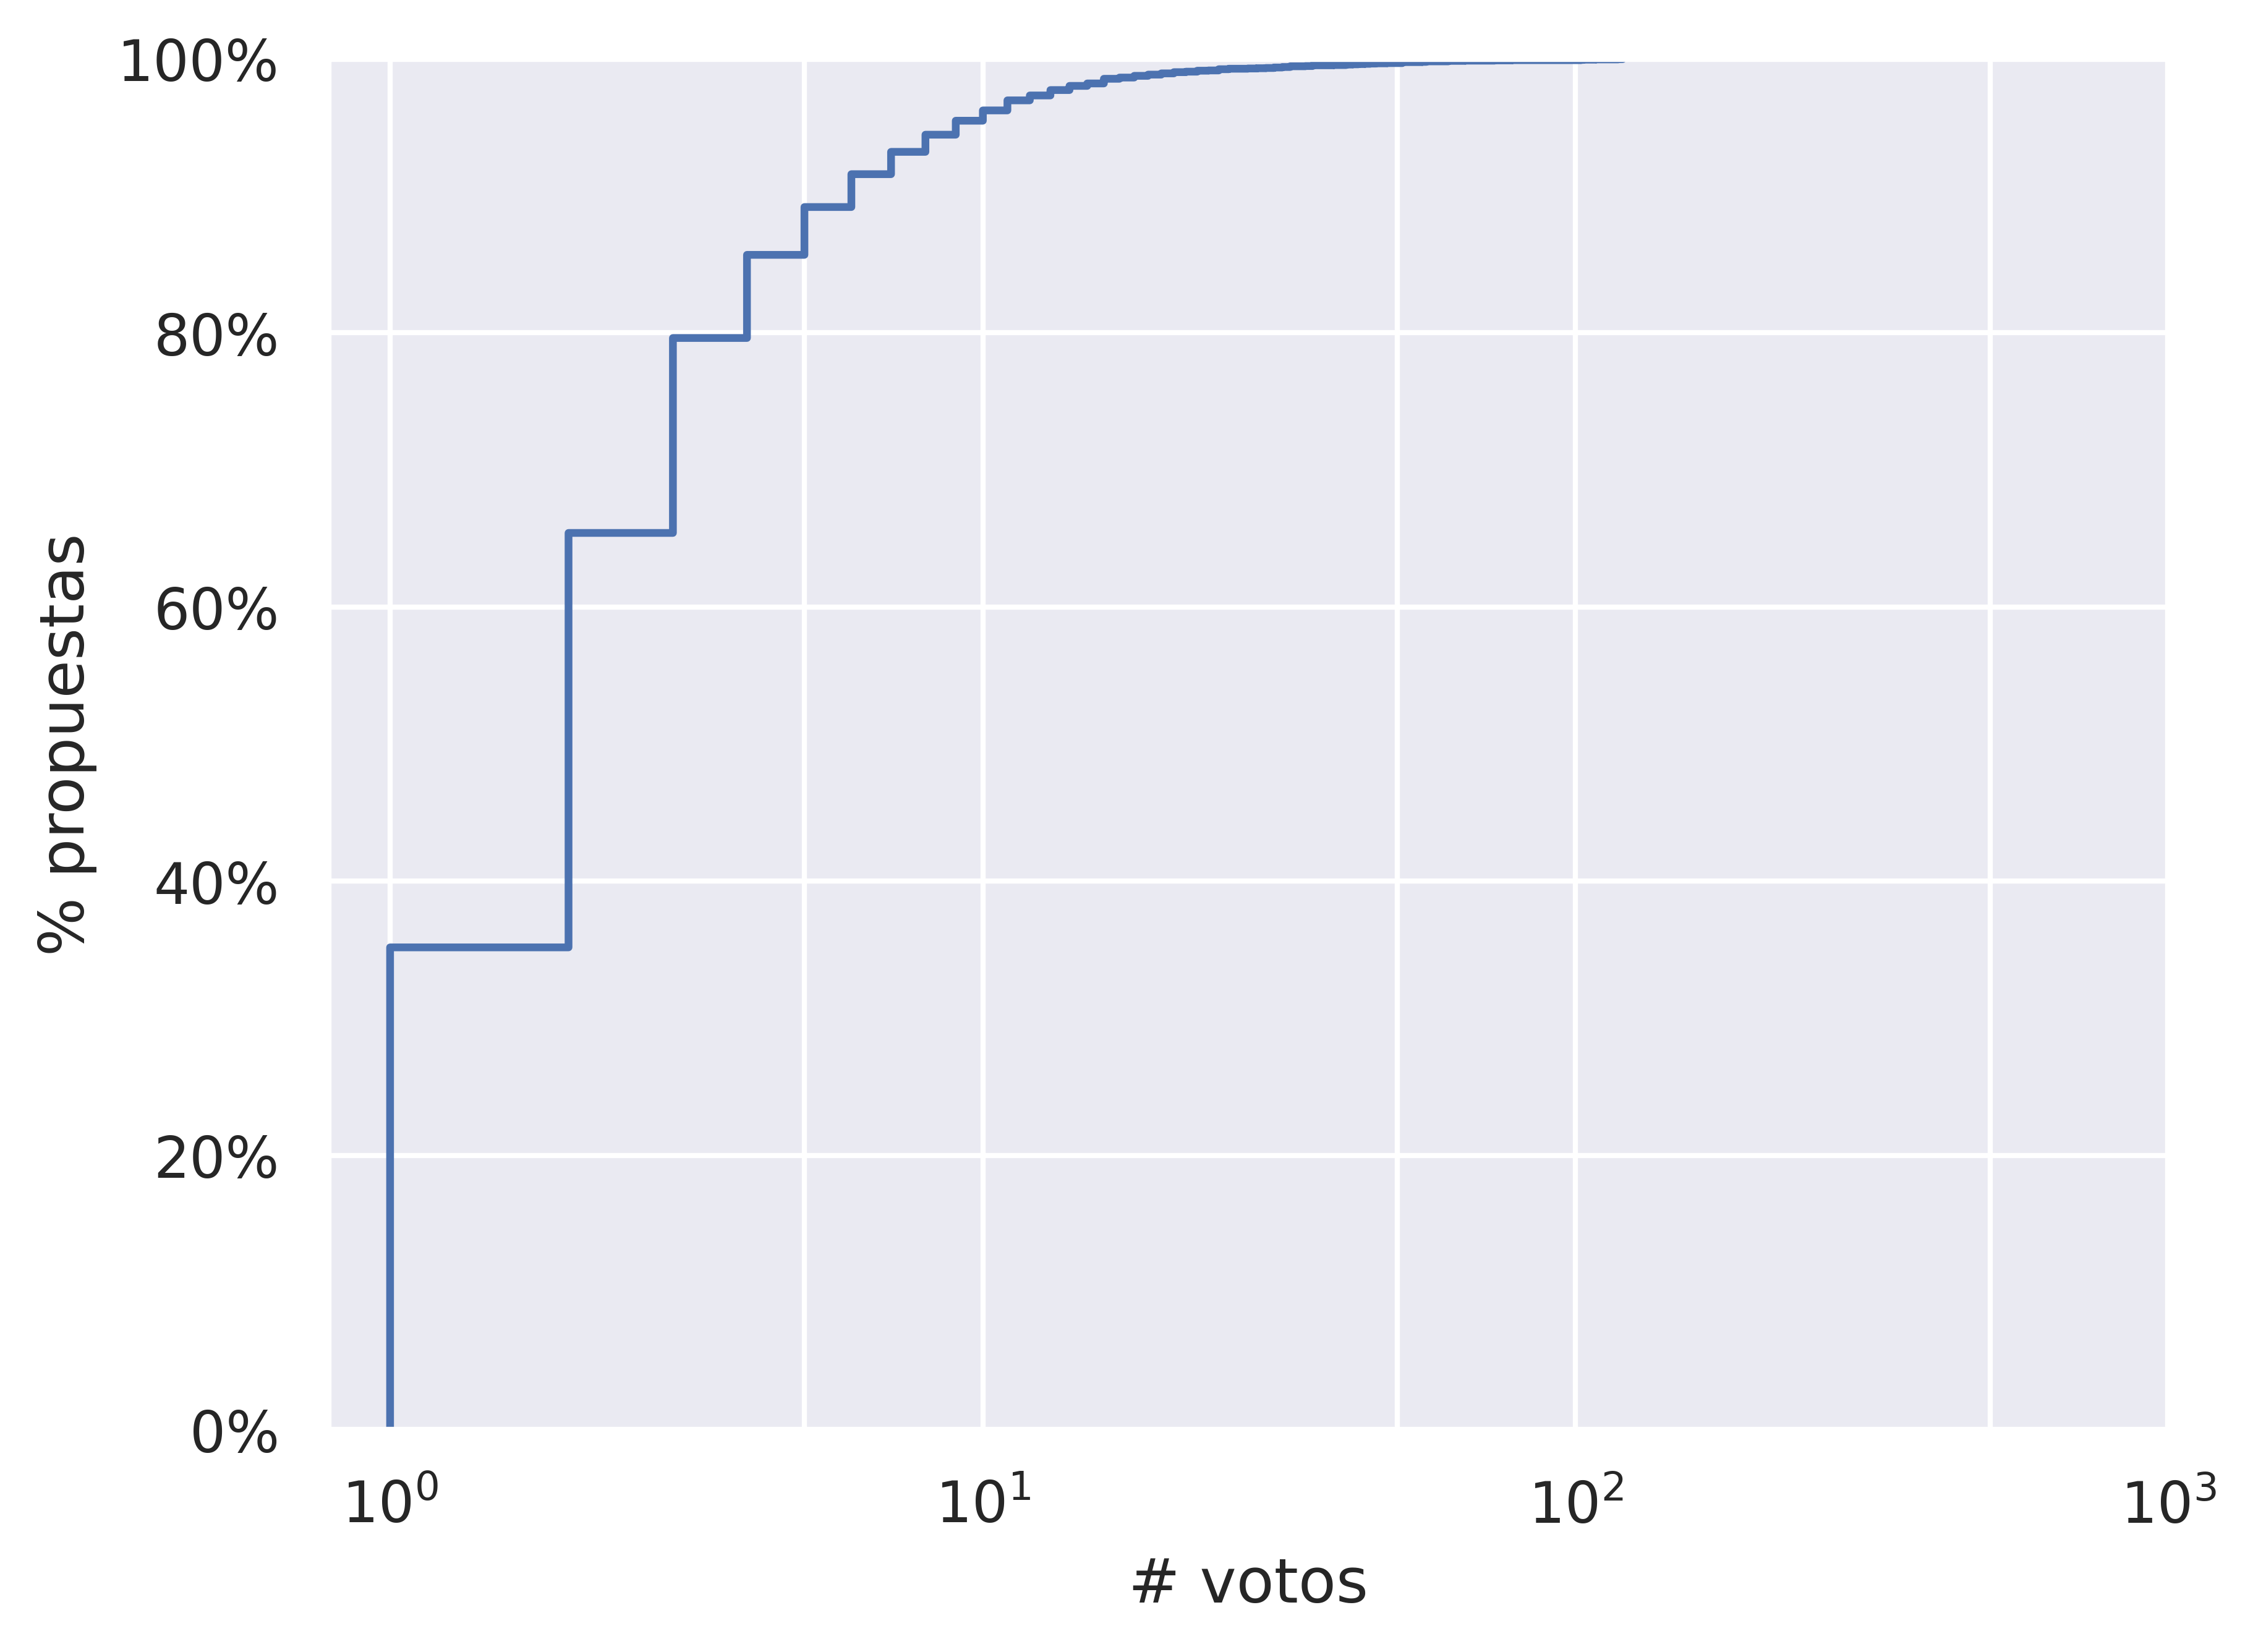

In [8]:
_toplot = dfp['votes_count']
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xlabel('# votos')
plt.ylabel('% propuestas')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_proposals_{ORG_NAME}.pdf')

count    5591.000000
mean        3.172599
std         5.710431
min         1.000000
50%         2.000000
75%         3.000000
90%         6.000000
95%         9.000000
99%        21.000000
max       120.000000
dtype: float64
0


<Axes: ylabel='Proportion'>

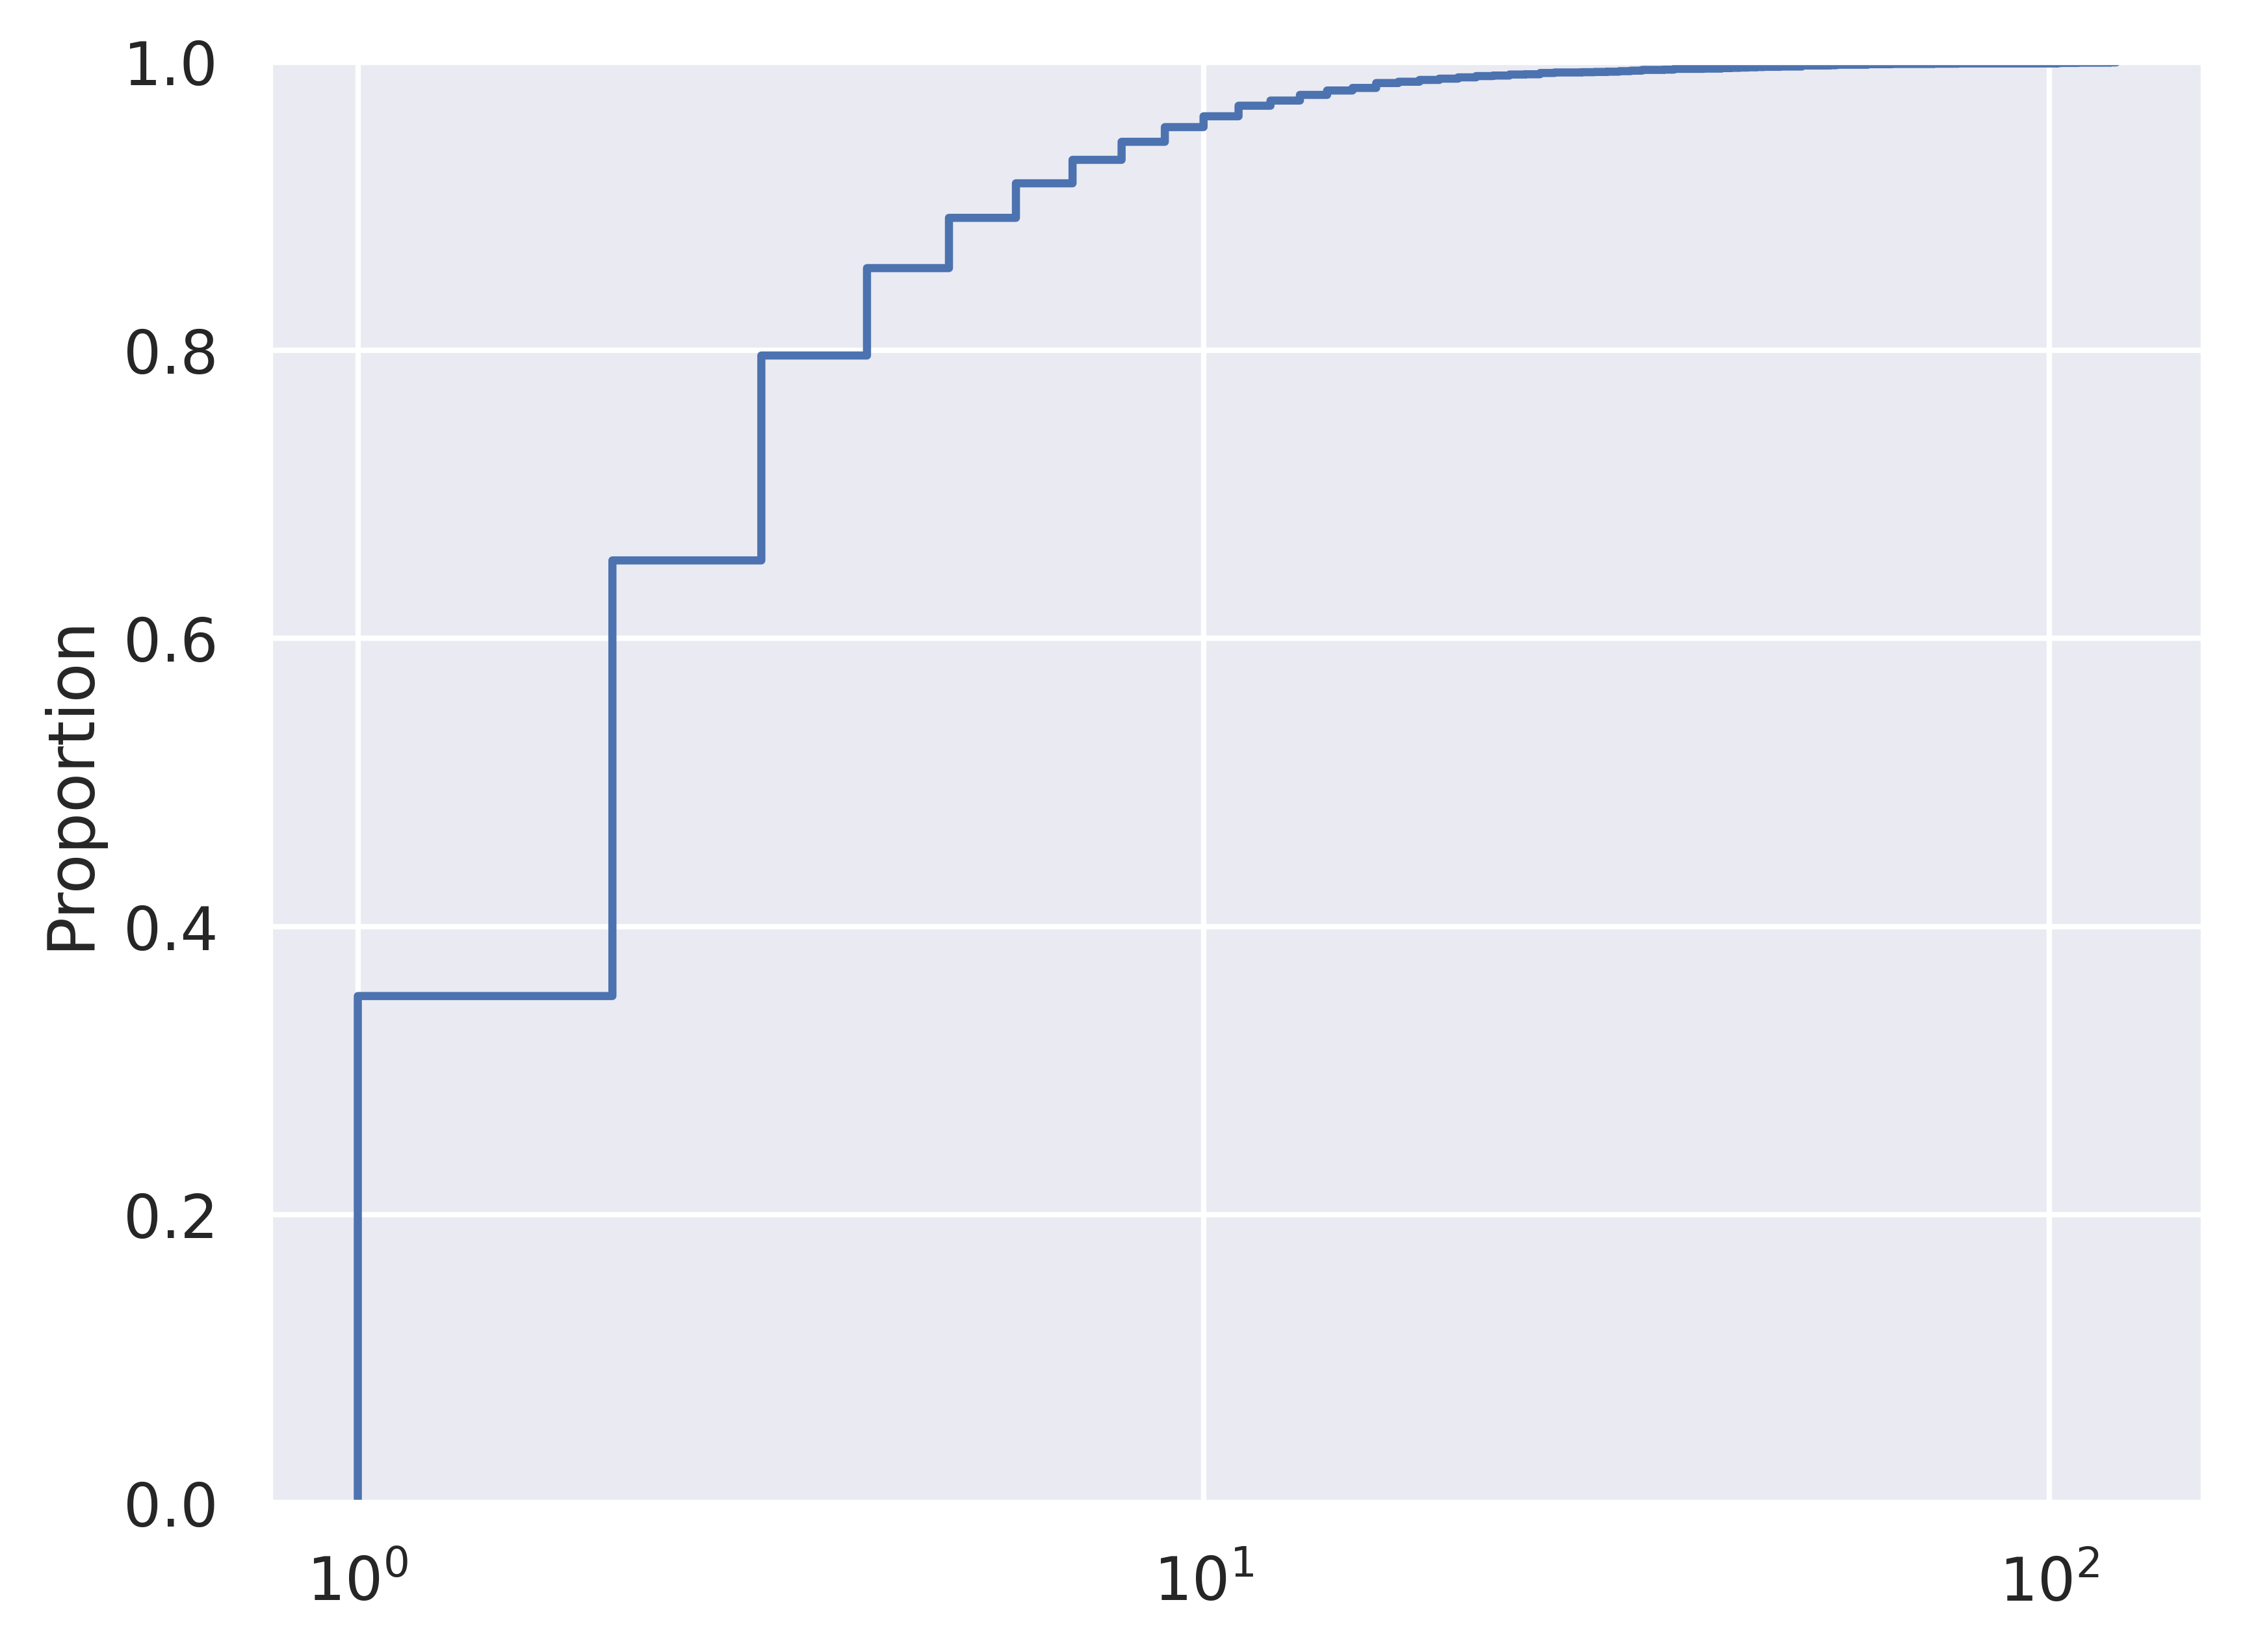

In [9]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )
sns.ecdfplot(_toplot, log_scale=True)

### Usuarios activos

In [10]:
# dfv.set_index('date').sort_index()['voter'].tolist()
# for x in dfv.set_index('date').sort_index()['voter'].items():
#     print(x)

/tmp/ipykernel_181589/3928196604.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/17738 [00:00<?, ?it/s]

2020-11-25 14:31:40 2022-07-26 17:09:25


Cannot show ipywidgets in text

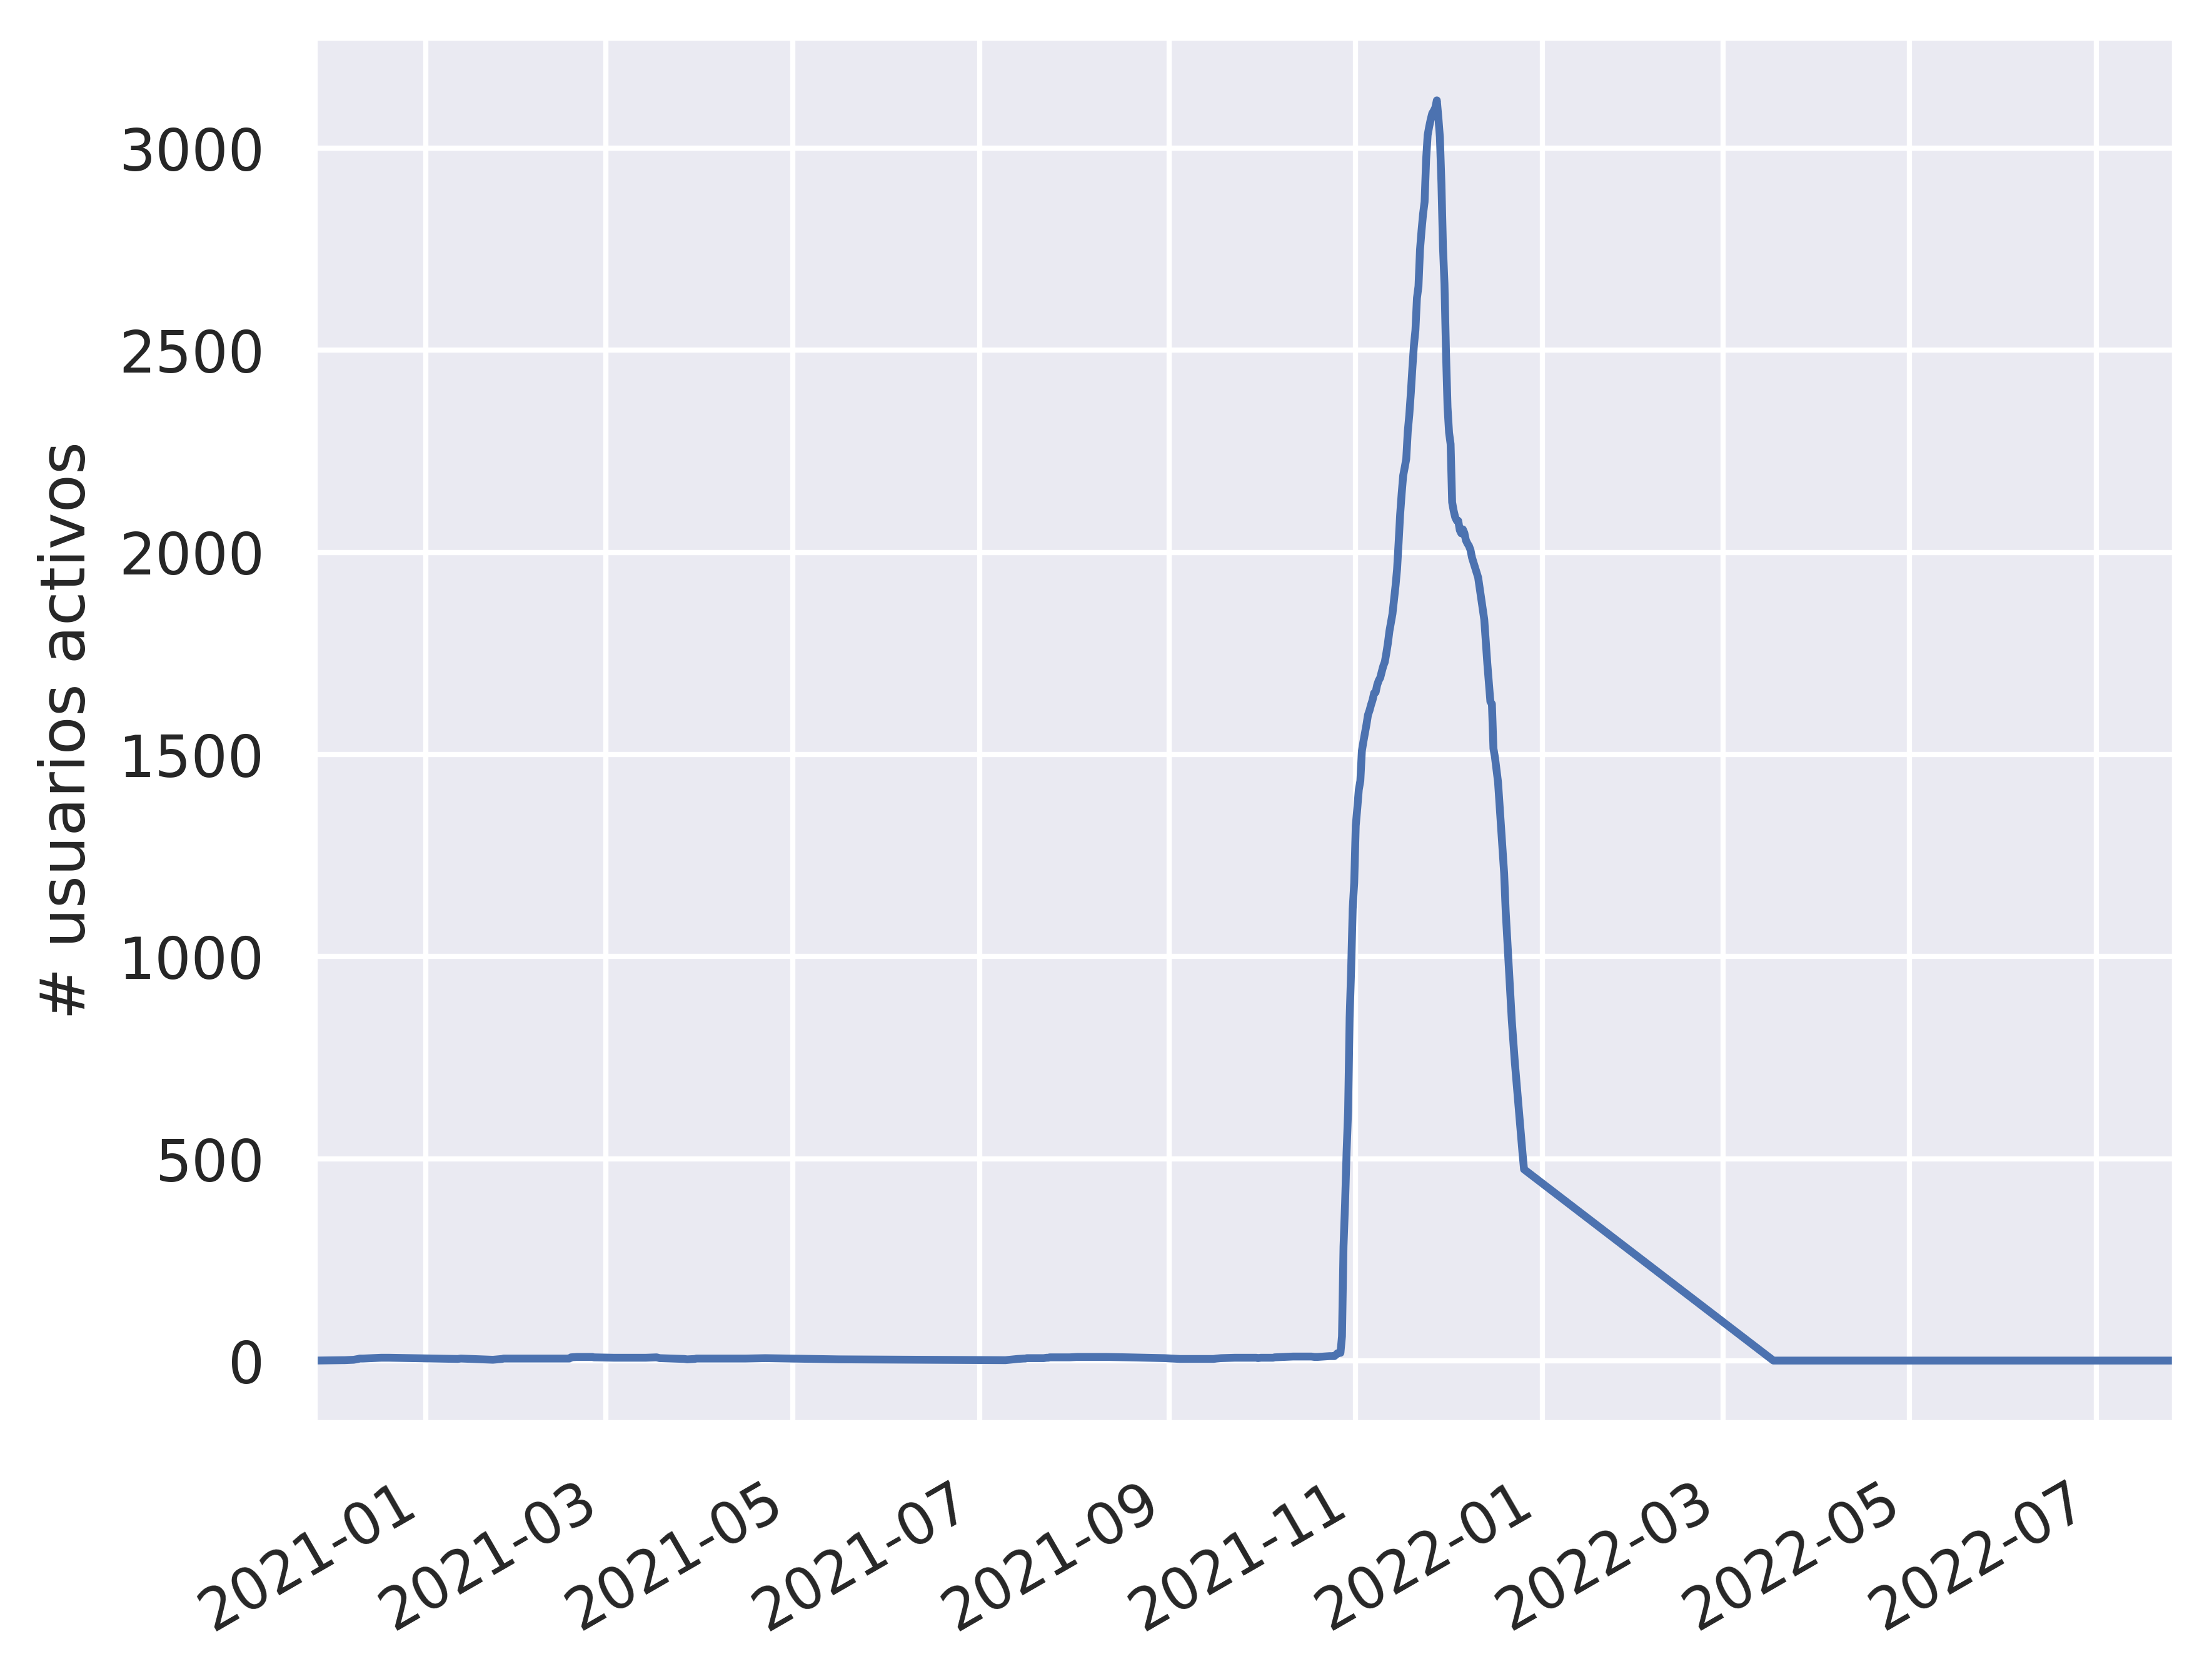

In [11]:
# import numba
from tqdm.autonotebook import tqdm
import rolling
import datetime as dt

tqdm.pandas(total=len(dfv))

# WINDOW_SIZE = '30D'
WINDOW_SIZE = dt.timedelta(days=30)

RESAMPLE_FREQ = '12h'

# @numba.jit(nopython=True)
# def nunique(arr):
#     return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
# dfv['ucode'] = dfv['voter'].cat.codes
#_cnt = dfv.set_index('date').sort_index().rolling(WINDOW_SIZE)['ucode'].progress_apply(nunique, raw=True).rename('cnt')

# Al final resulta que lo mejor era ir a por la solución O(1)
_voters = dfv.set_index('date').sort_index()['voter'] # .cat.codes
r = tqdm(
    rolling.arithmetic.Nunique(_voters.items(), WINDOW_SIZE, window_type='indexed'),
    total=len(dfv),
)
_cnt = pd.Series(r, index=_voters.index)
# Need to resample or there would be too many points
_cnt = _cnt.resample(RESAMPLE_FREQ).max()

print(dfv['date'].min(), dfv['date'].max())
ax = sns.lineplot(_cnt)
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# usuarios activos')
plt.xlim(dfv['date'].min(), dfv['date'].max())
nbutils.download_matplotlib(ax.figure, f'04c_rolling_voters_{WINDOW_SIZE}_{ORG_NAME}.png')

## Cuando se unen los usuarios

Es decir, cuando votan por primera vez

Cannot show ipywidgets in text

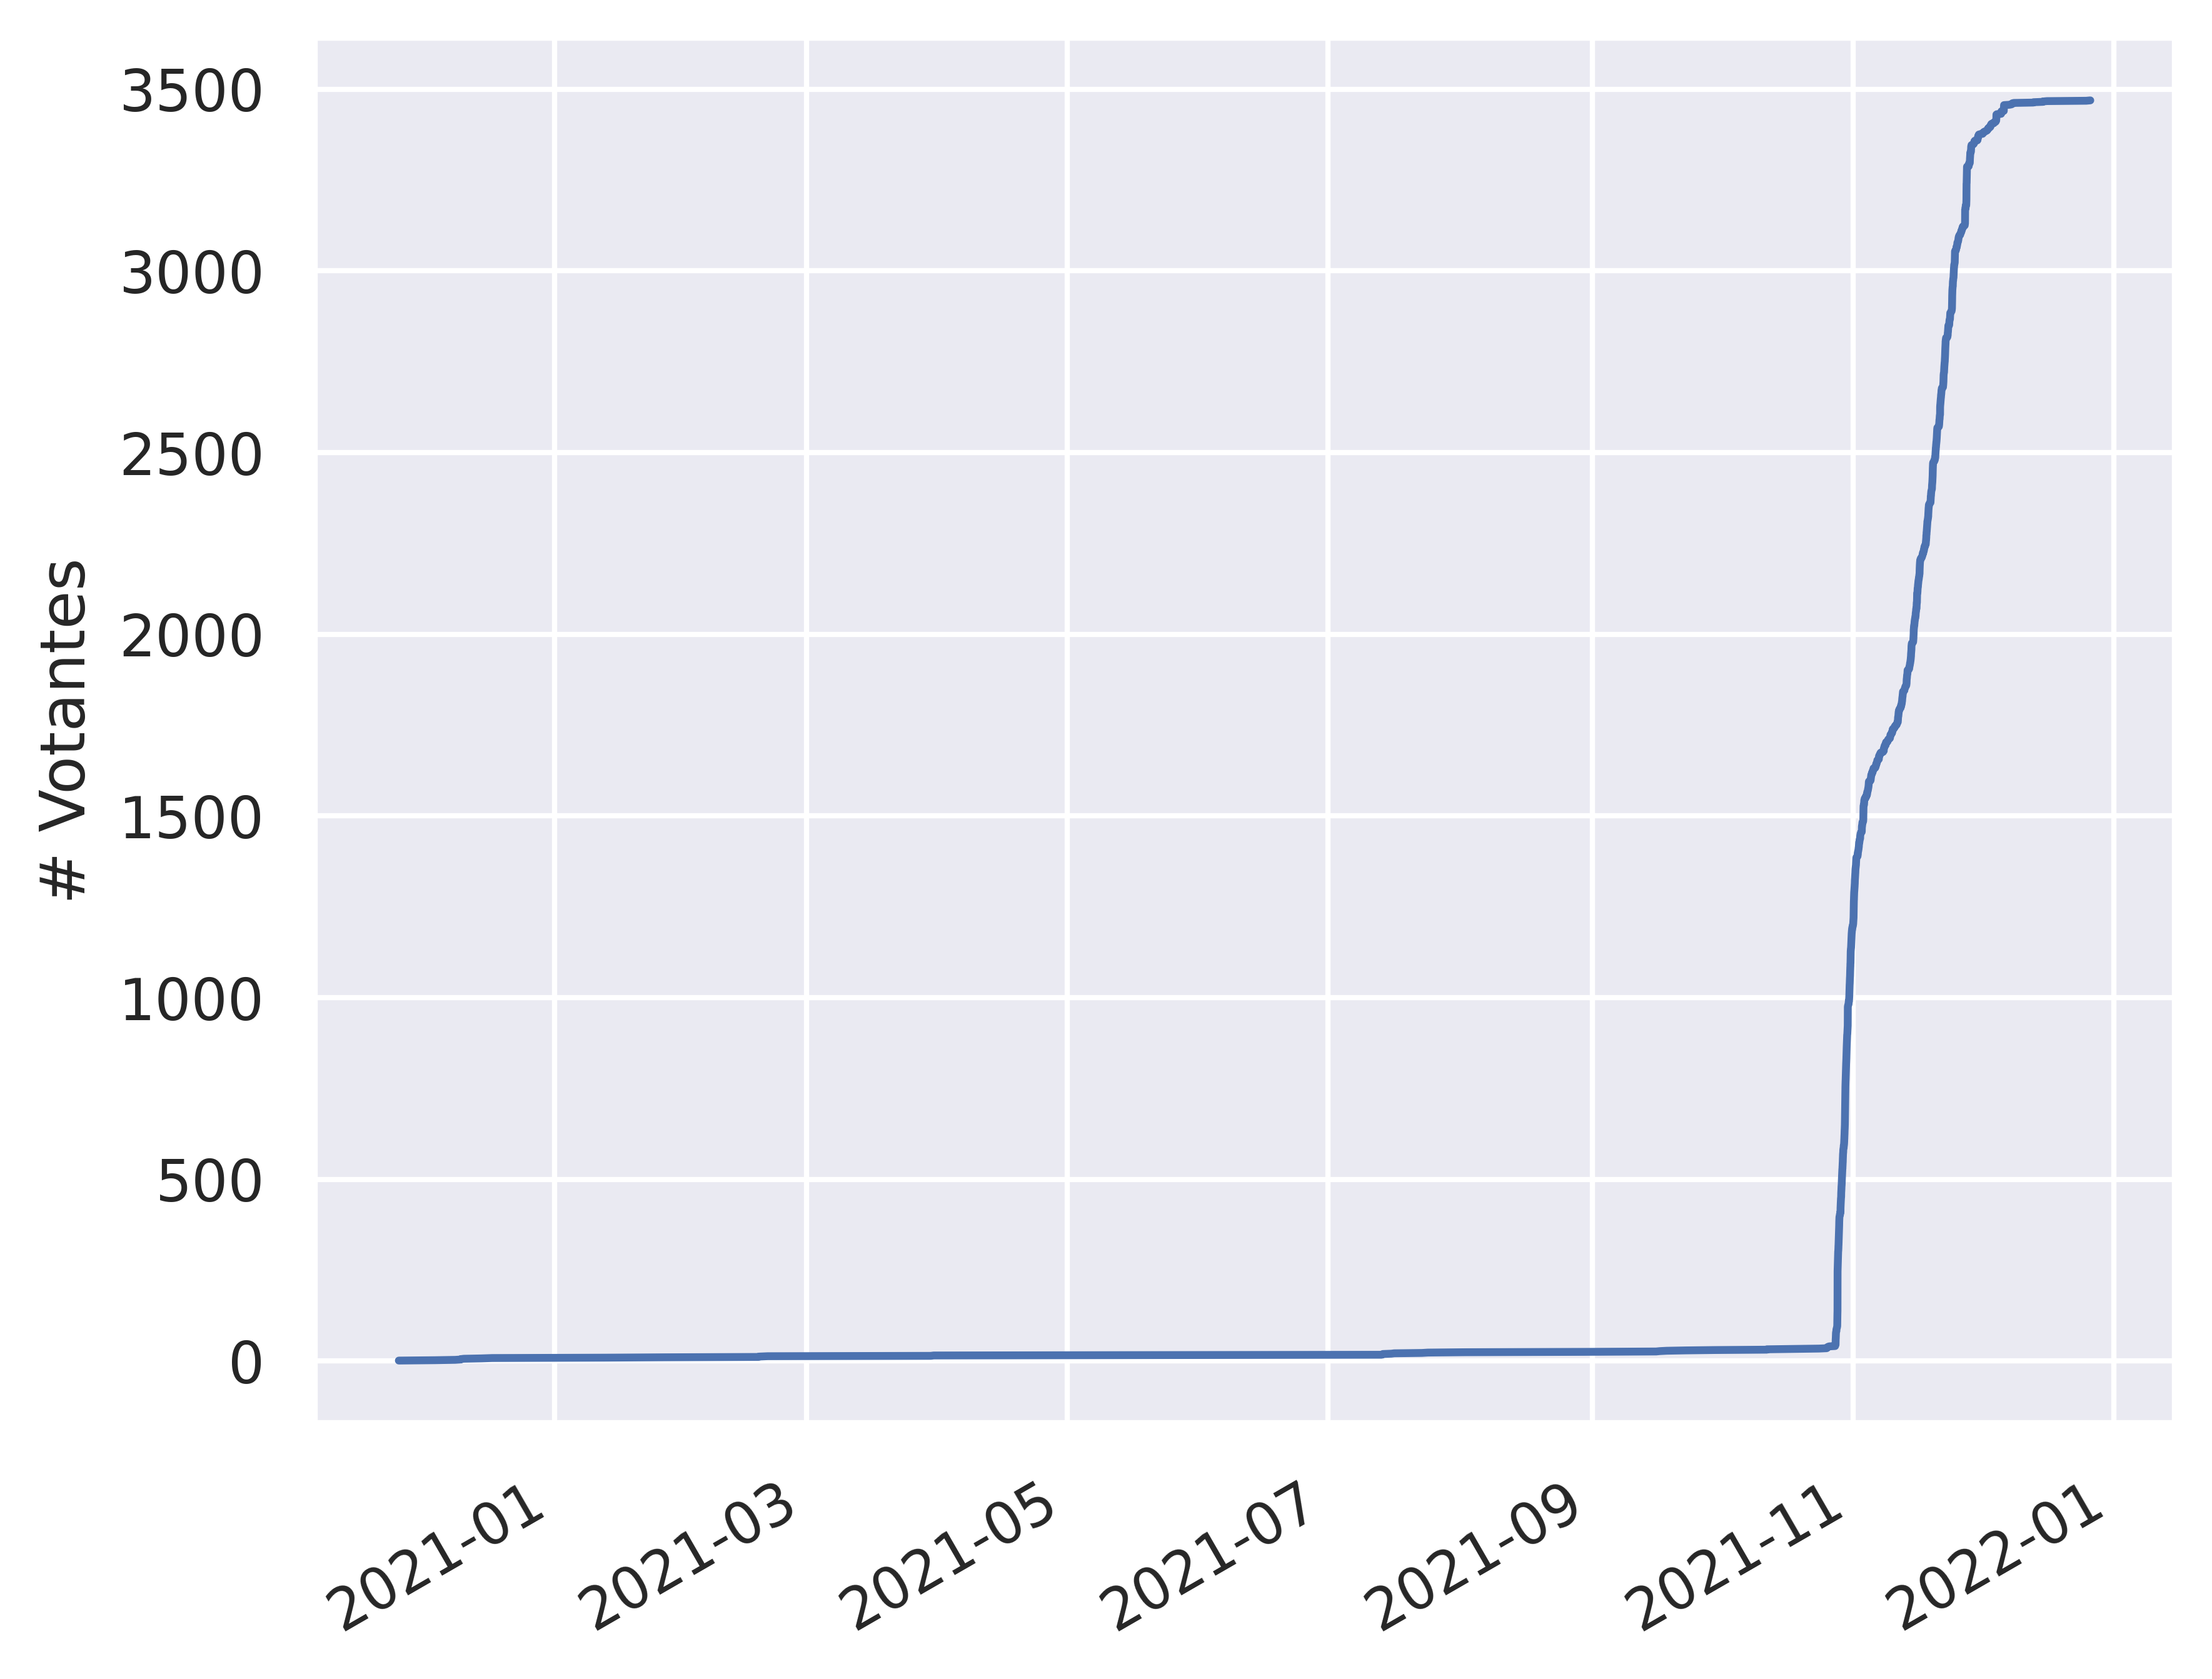

In [12]:
_toplot = dfv.groupby('voter')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Votantes')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_cumcnt_users_{ORG_NAME}.pdf')

## Cuando se crean las propuestas

Cannot show ipywidgets in text

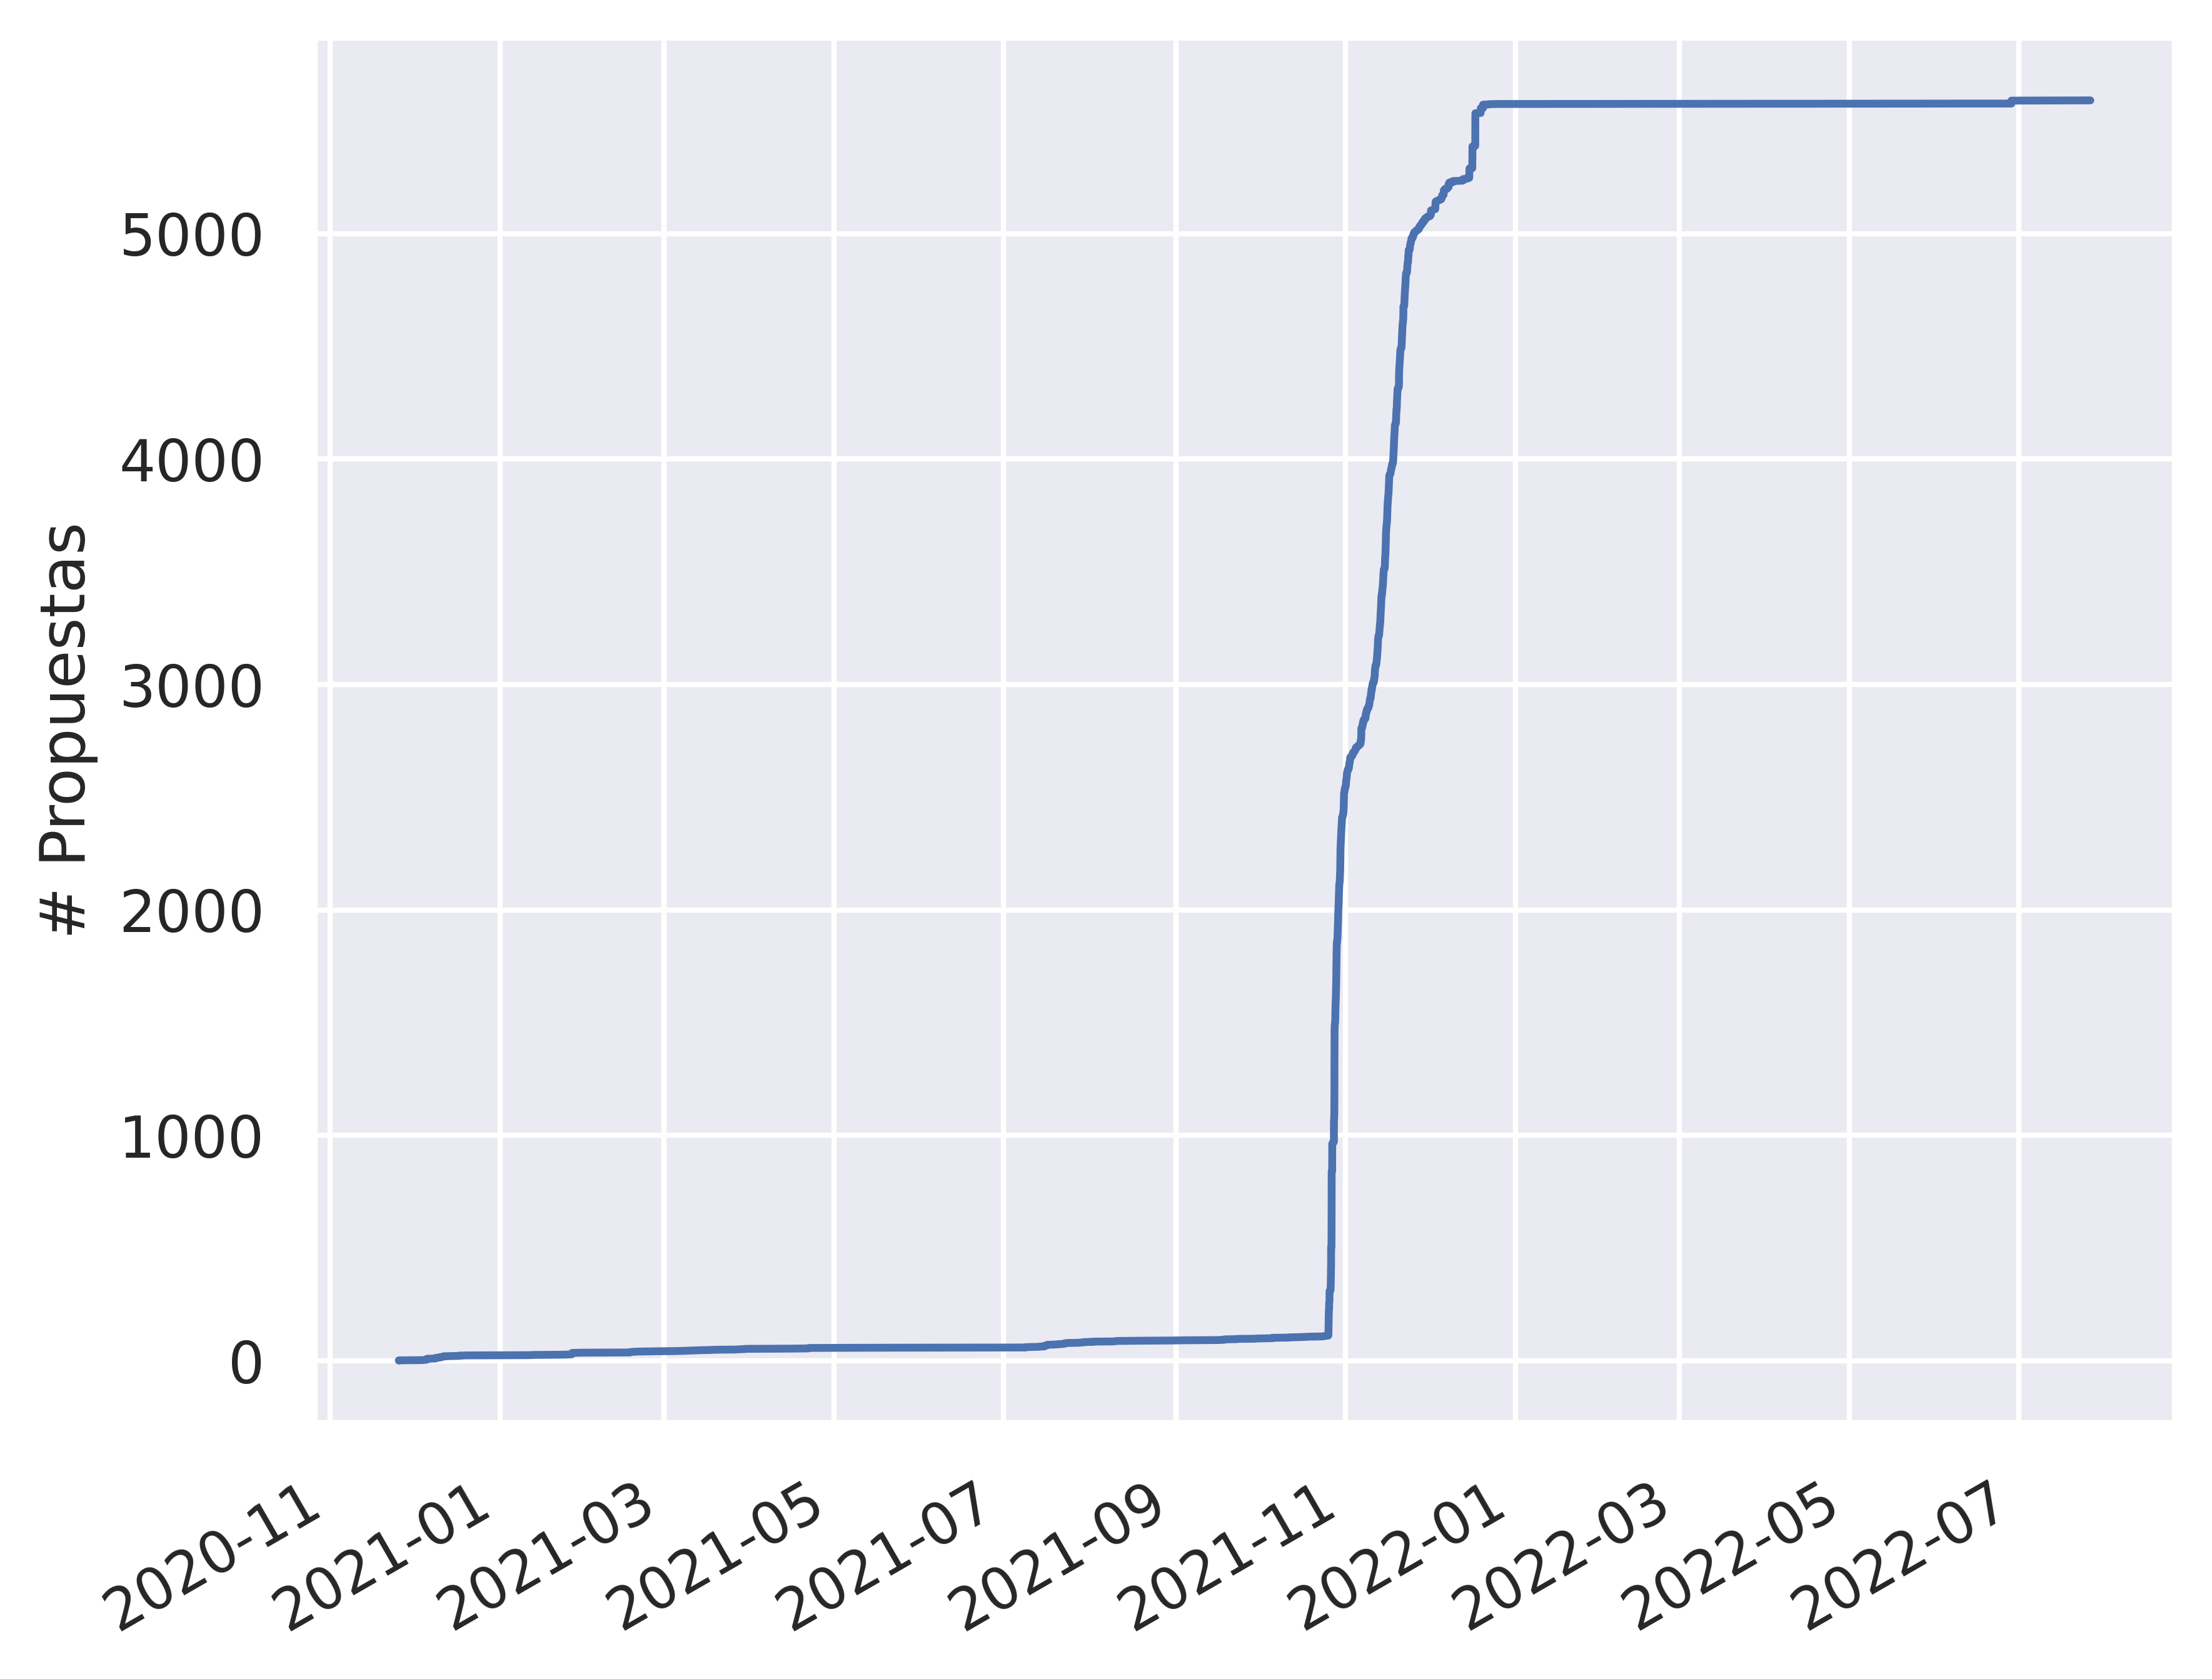

In [13]:
_toplot = dfv.groupby('proposal')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Propuestas')

nbutils.download_matplotlib(ax.figure, f'04c_cumcnt_users_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

<Figure size 3840x2880 with 0 Axes>

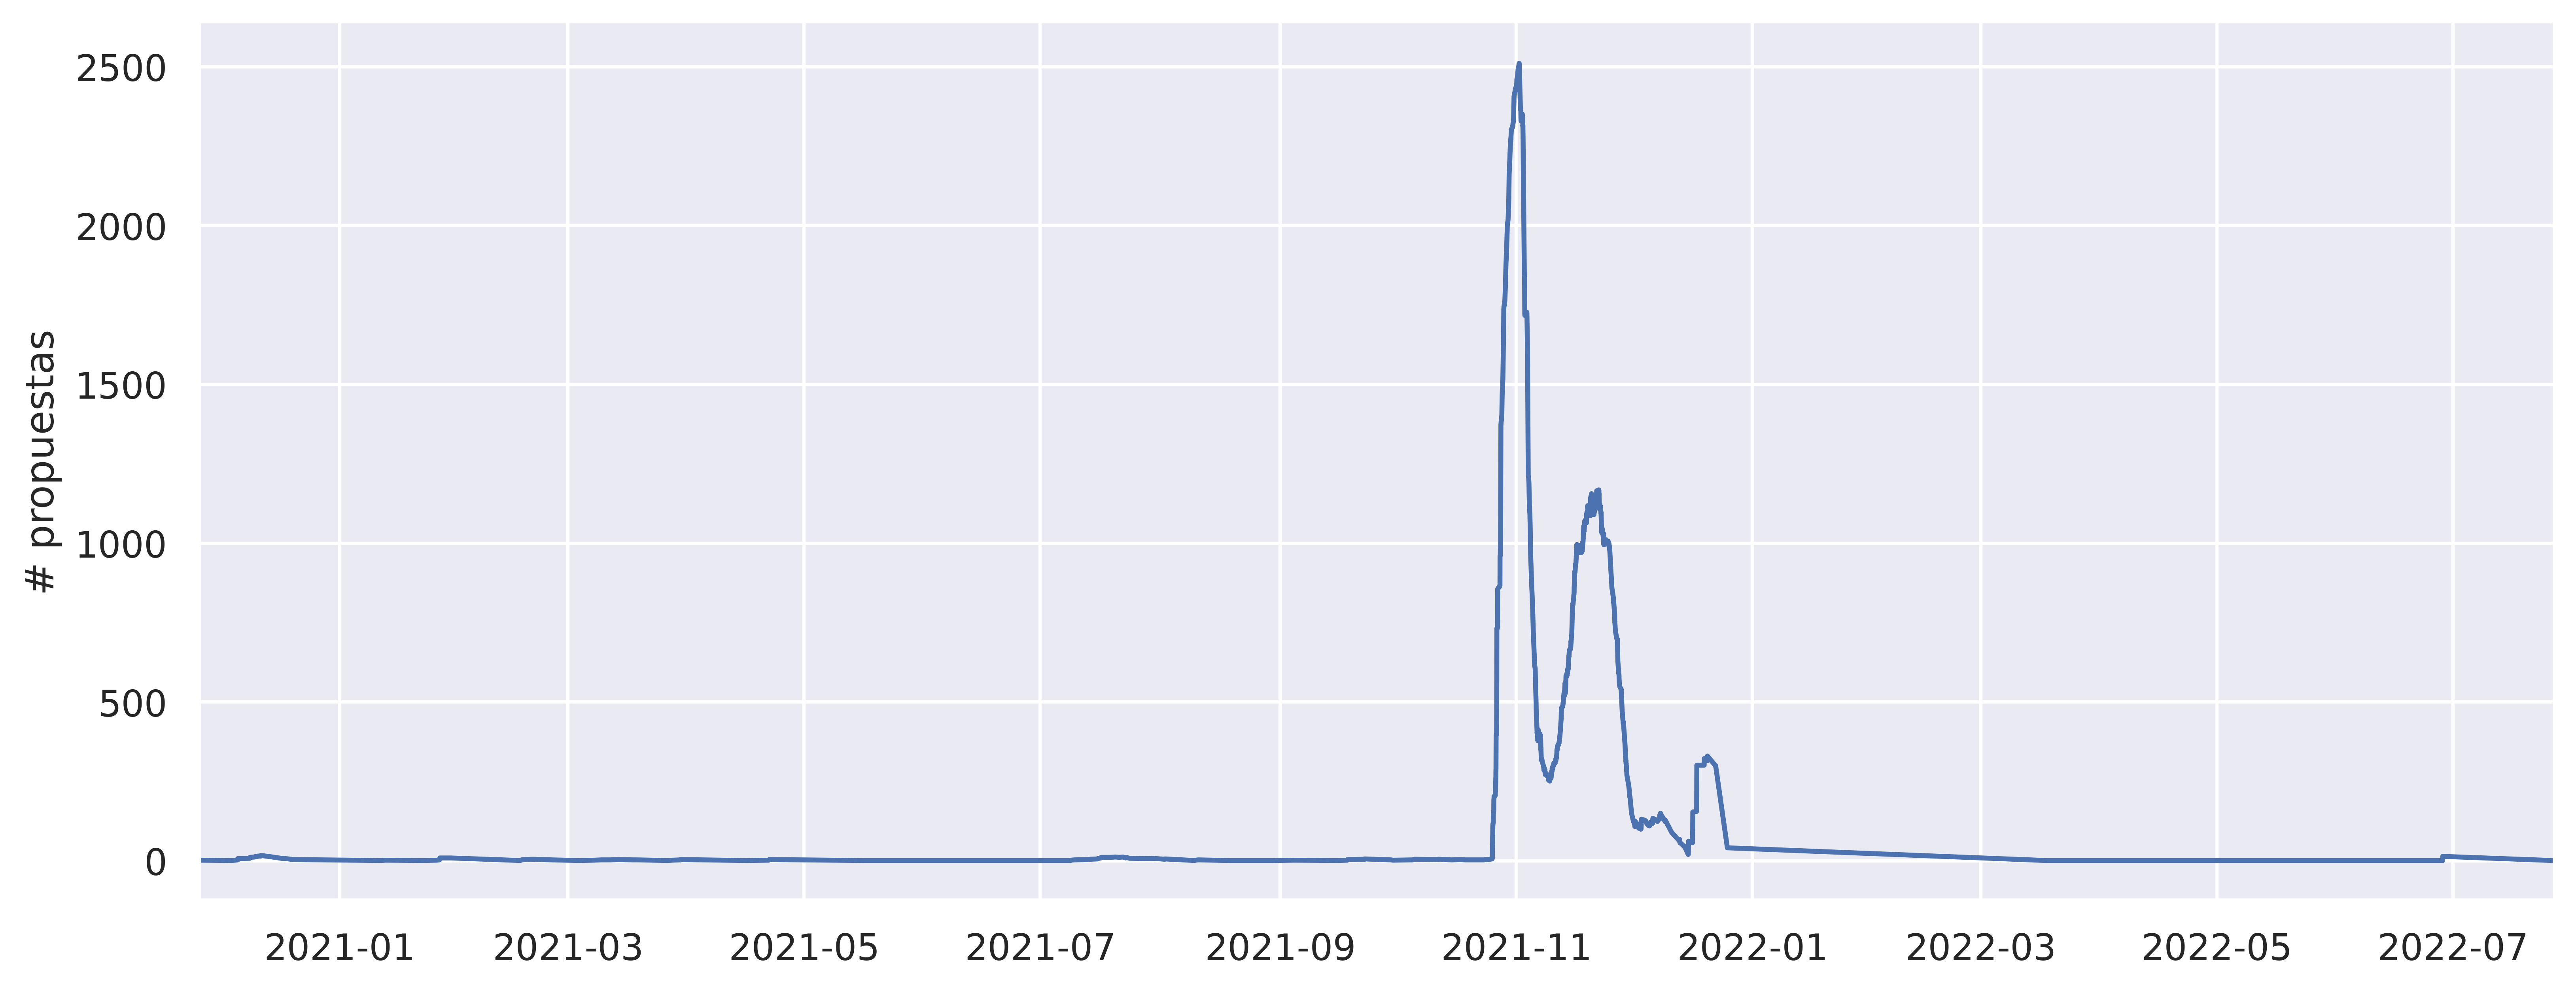

In [14]:
WINDOW_SIZE = '7D'

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=(fs[0]*2, fs[1]))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()
nbutils.download_matplotlib(ax.figure, f'04c_rolling_proposals_{WINDOW_SIZE}_{ORG_NAME}.pdf')

## Dia de la semana en que se votan las propuestas

> incluso, se podría hacer un heatmap X cuando se lanzan Y cuando se votan y Z (color) la frecuencia
> -- Javi

Vamos, que en esta celda vamos a intentar hacer un HEATMAP donde:
- X: dia de la semana de creación de la propuesta
- Y: dia de la semana de votación
- Z: número de votos

In [15]:
_toplot.to_numpy()

array([[Timestamp('2020-11-25 14:31:40'), 1.0],
       [Timestamp('2020-11-25 14:34:40'), 2.0],
       [Timestamp('2020-12-04 01:16:40'), 1.0],
       ...,
       [Timestamp('2022-06-28 08:18:30'), 13.0],
       [Timestamp('2022-06-28 08:19:45'), 14.0],
       [Timestamp('2022-07-26 17:09:25'), 1.0]], dtype=object)

Text(277.49999999999994, 0.5, 'Día votación')

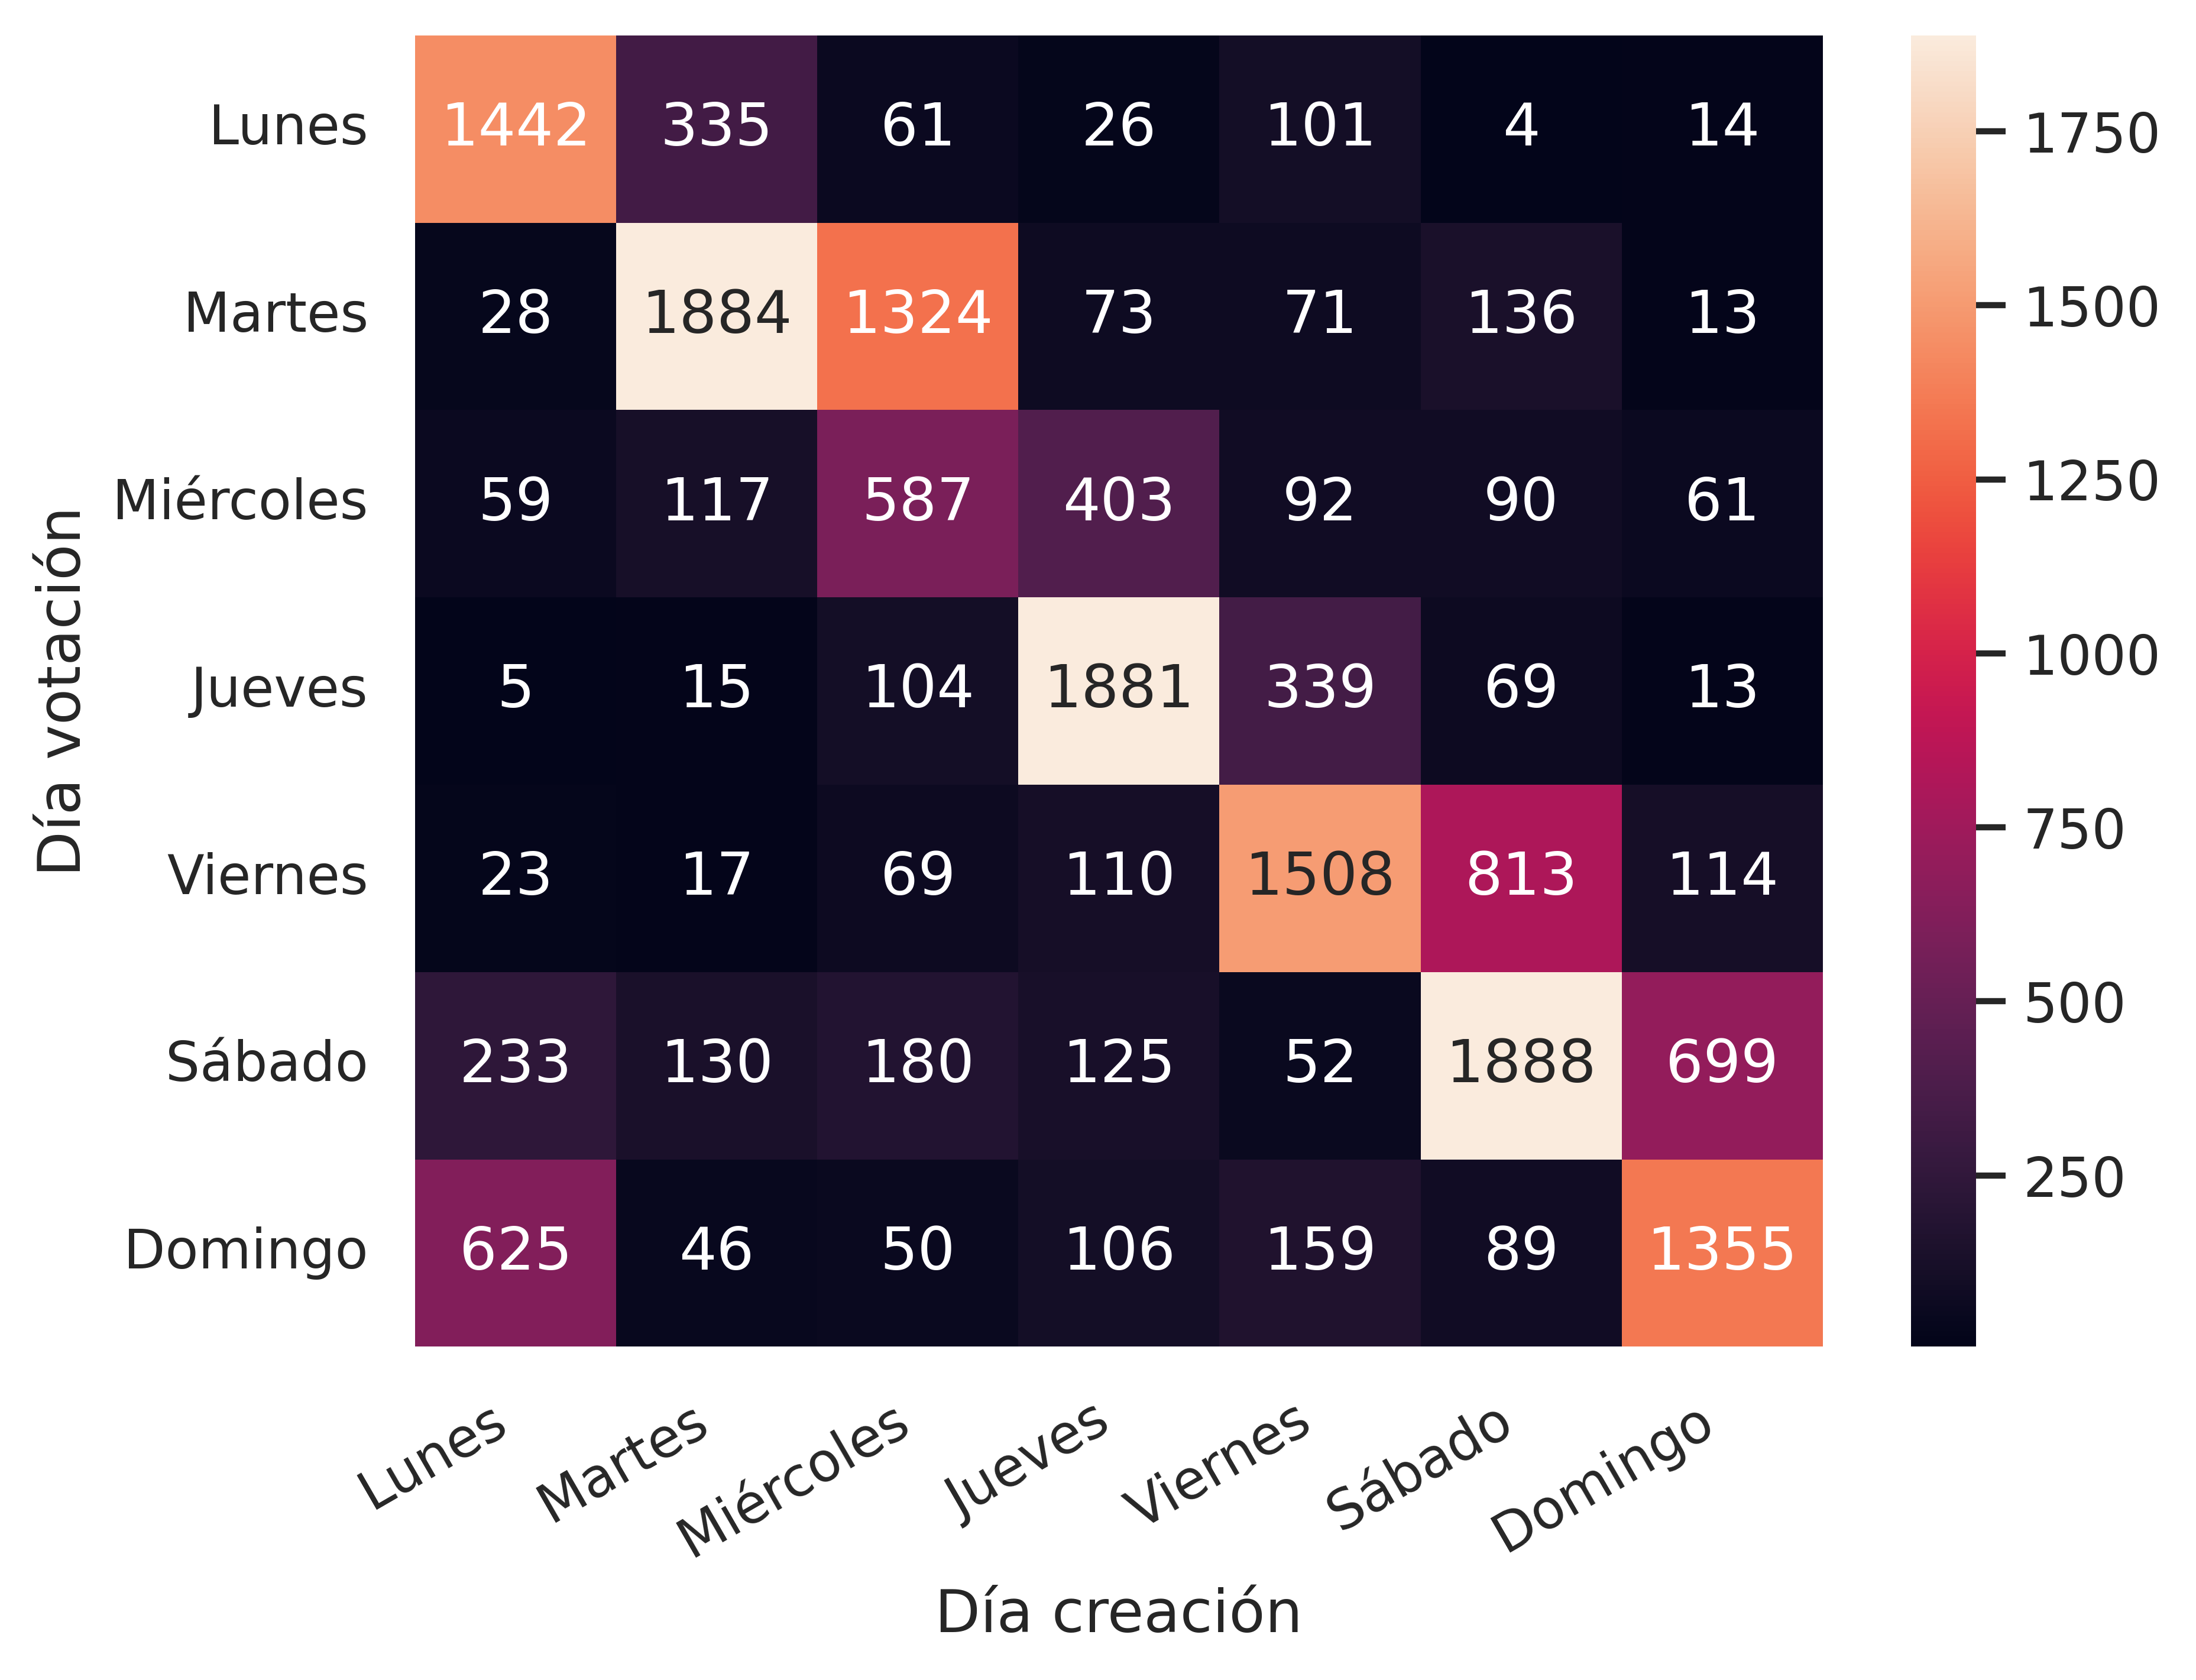

In [16]:
# In pandas, 0 = Monday
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

spanish_dow = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes', 
    5: 'Sábado',
    6: 'Domingo',
}

_dfvp = dfv.merge(dfp['date'].rename('proposal_date'), left_on='proposal', right_index=True)
_dfvp['date_dow'] = _dfvp['date'].dt.day_of_week
_dfvp['proposal_date_dow'] = _dfvp['proposal_date'].dt.dayofweek
# sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
_toplot = pd.crosstab(_dfvp['proposal_date_dow'], _dfvp['date_dow']).rename(index=spanish_dow, columns=spanish_dow)

sns.heatmap(_toplot, annot=True, fmt='g')
plt.xticks(rotation=30, ha='right')

plt.xlabel('Día creación')
plt.ylabel('Día votación')

Cannot show ipywidgets in text

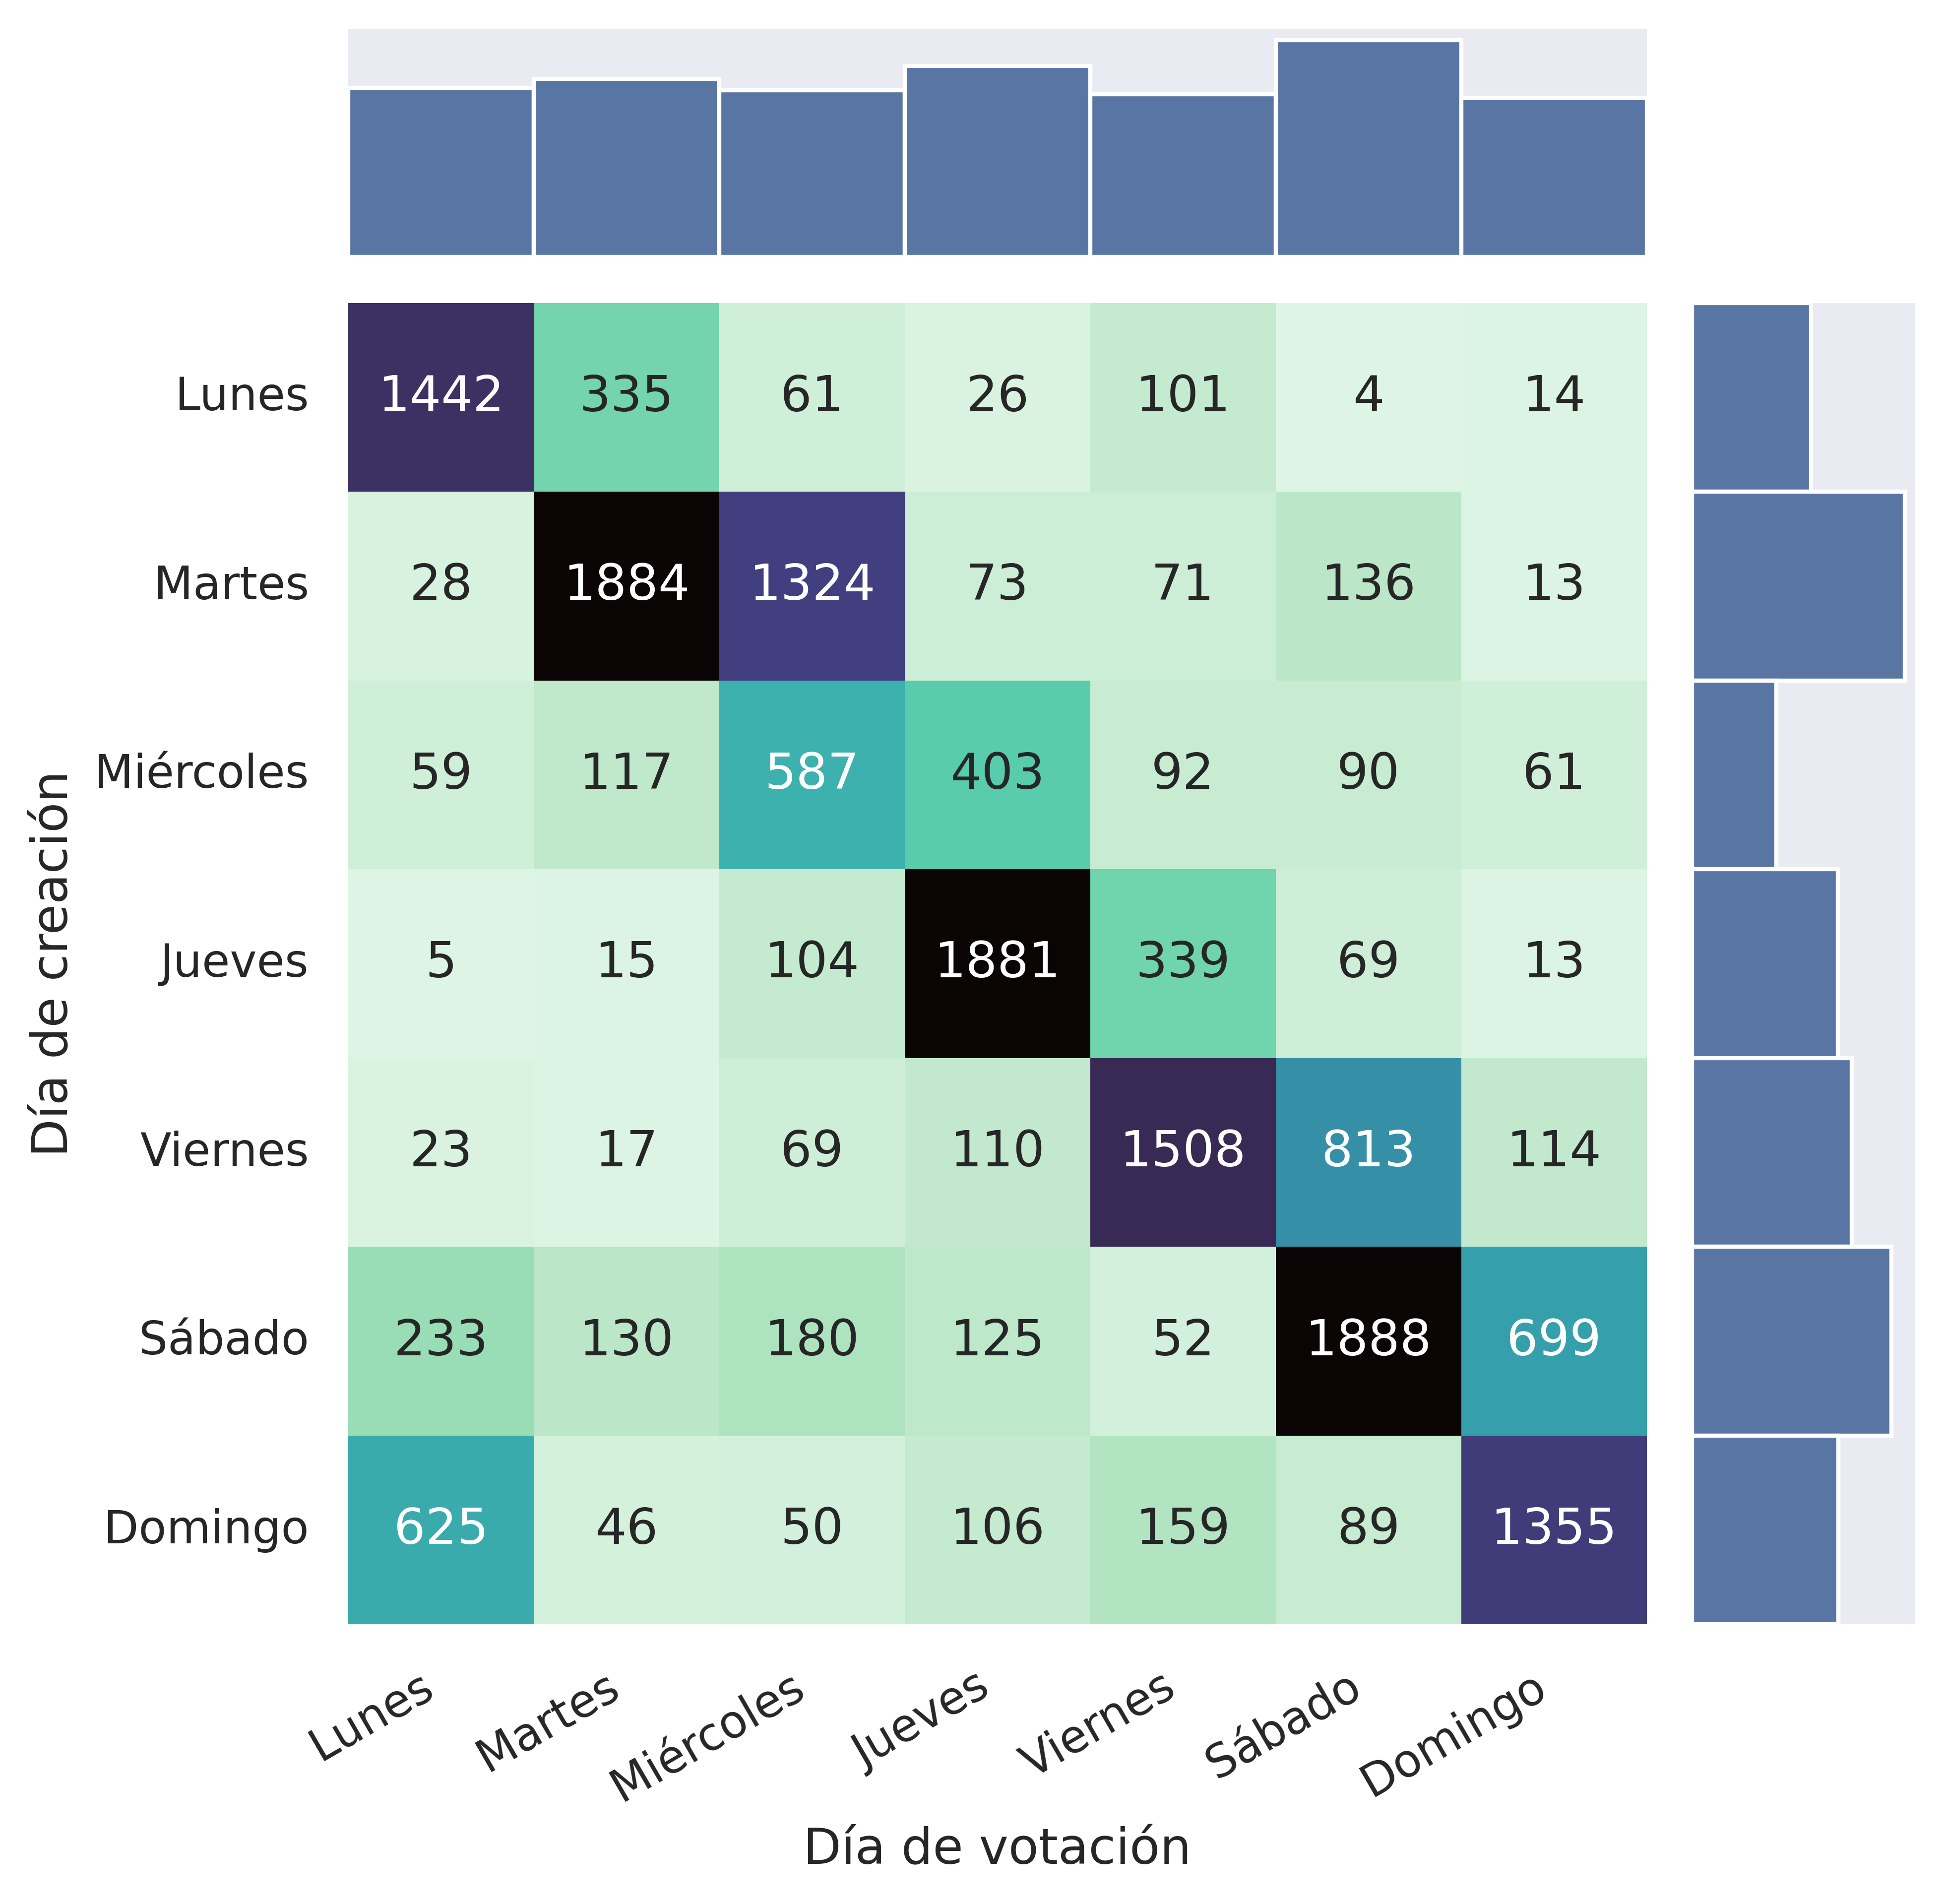

In [17]:
# _toplot = pd.crosstab(...)

grid = sns.JointGrid()

sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt='g', cmap='mako_r')
sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=1)
sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=1)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

grid.ax_joint.set_xticklabels(grid.ax_joint.get_xticklabels(), rotation=30, ha='right')
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Día de votación')
grid.ax_joint.set_ylabel('Día de creación')

nbutils.download_matplotlib(grid, f'04c_heatmap_proposals_{ORG_NAME}.pdf')

<Axes: xlabel='proposal_date_dow', ylabel='count'>

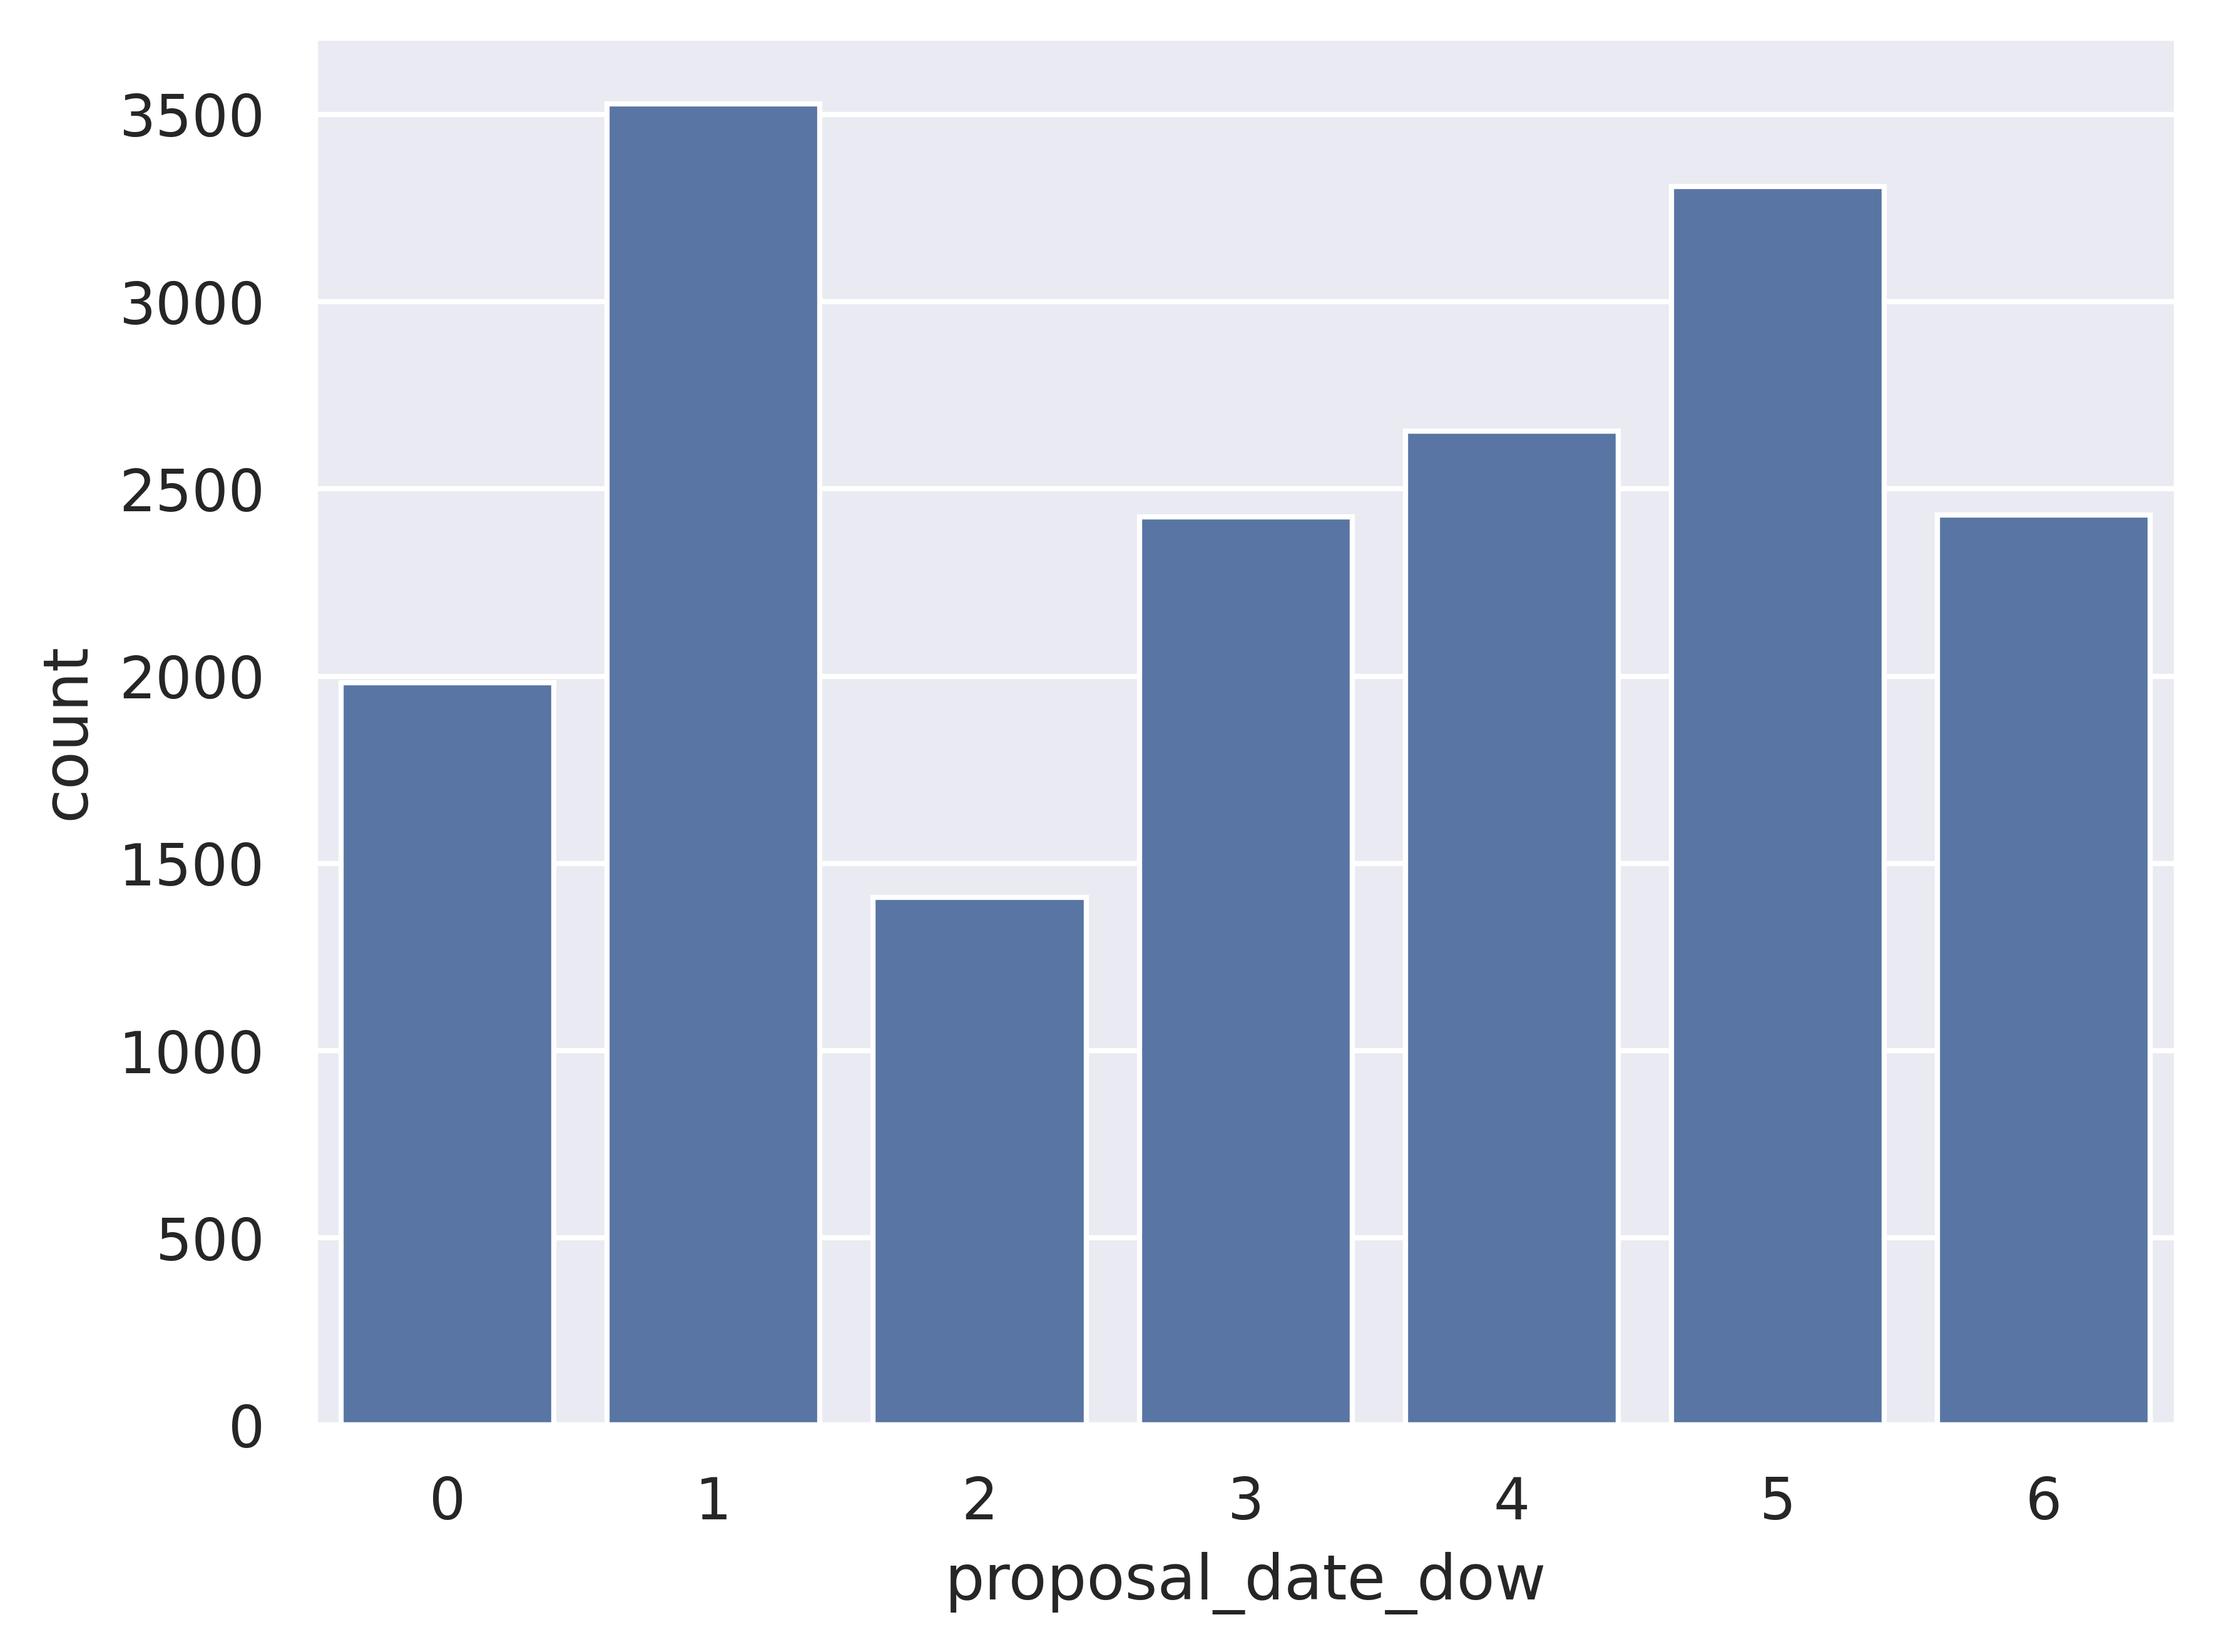

In [18]:
sns.countplot(_dfvp, x='proposal_date_dow')

<Axes: xlabel='count', ylabel='date_dow'>

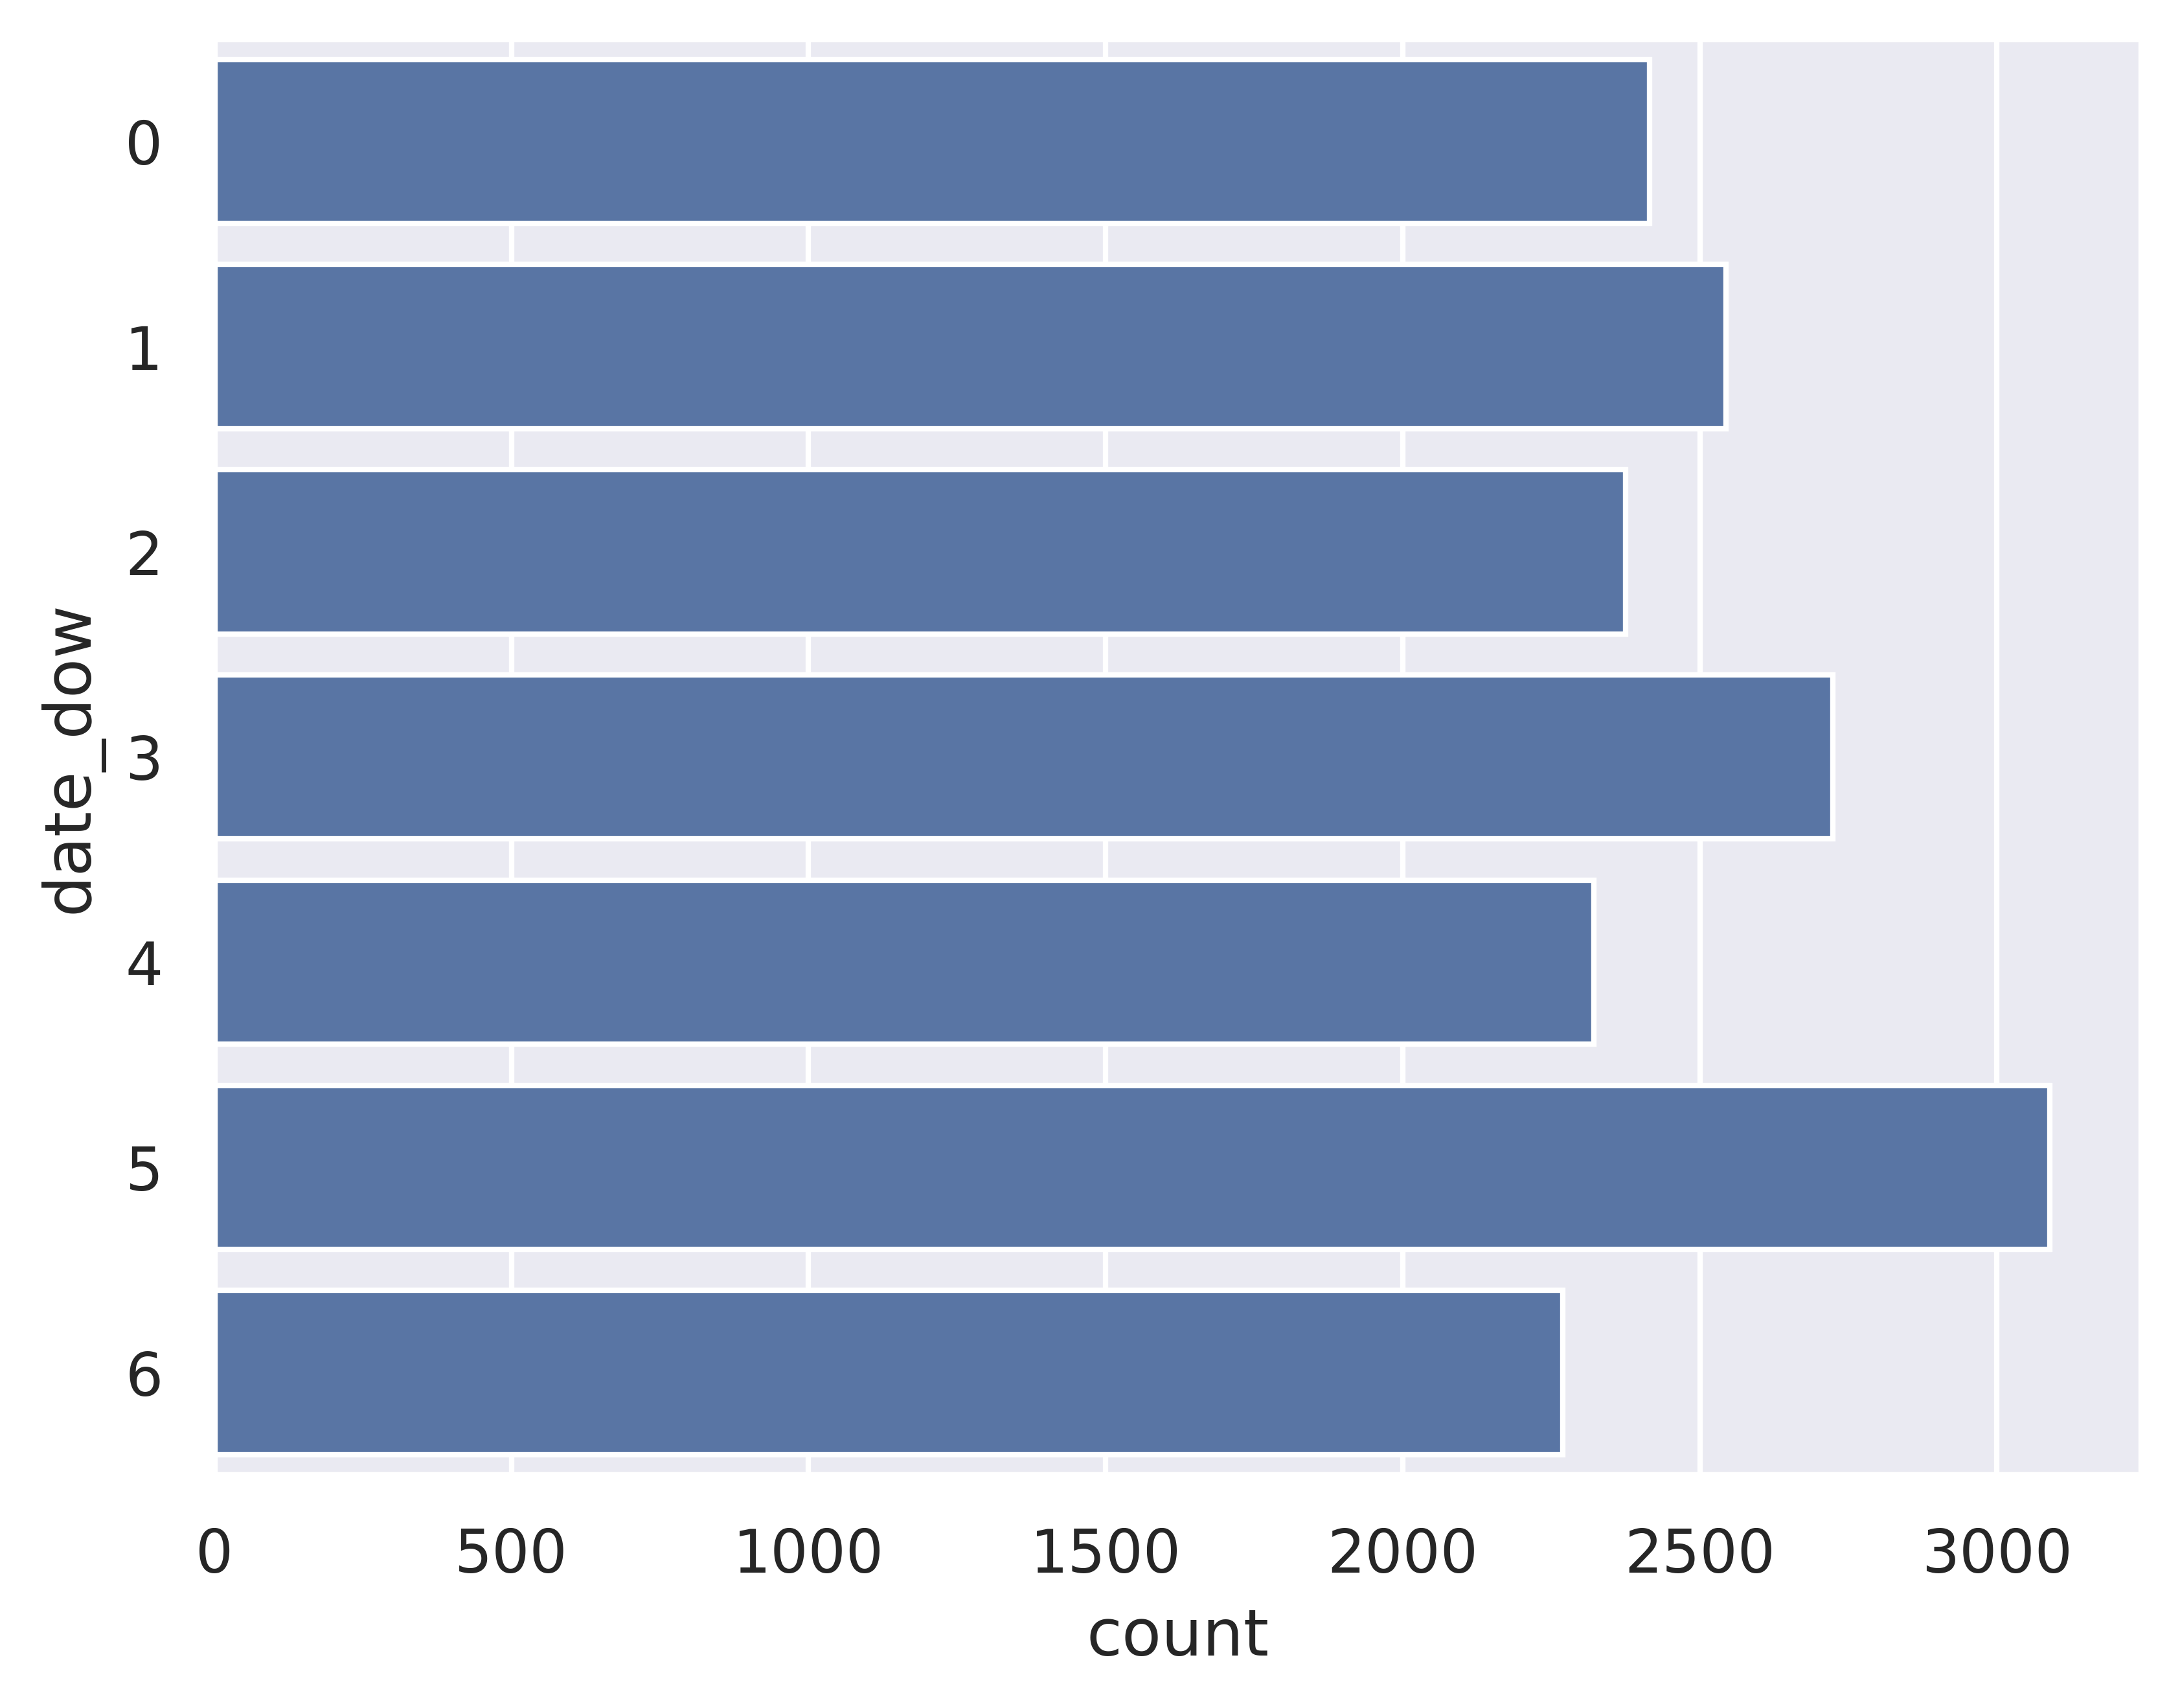

In [19]:
sns.countplot(_dfvp, y='date_dow')

## Suelen votarse las propuestas al principio o al final

In [20]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Histograma de tiempo de los votos en la propuesta {proposal}")
    return ax

# proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

## Ahora para TODOS los votos

Cuidado que este grafo puede estar sesgado por una sola propuesta

In [21]:
dfp

platform                 name  \
id                                                                   
9b0951e8-192b-5b68-8e1a-1b392e5b704f  daohaus  DEAD FoundationsDAO   
9903573c-d495-5c45-8209-c16ac4527667  daohaus  DEAD FoundationsDAO   
17e9fb4c-05c0-5163-82fe-379de42259ed  daohaus  DEAD FoundationsDAO   
dc8c2dff-27f3-52f6-9e43-766d11991398  daohaus  DEAD FoundationsDAO   
a4318561-08d2-5a65-8214-c180b9855f1b  daohaus  DEAD FoundationsDAO   
...                                       ...                  ...   
9d2cacf1-8e67-5918-8e73-a157a9816112  daohaus  DEAD FoundationsDAO   
1e43b9e0-1317-5c08-8d51-b3455ace6c7d  daohaus  DEAD FoundationsDAO   
40a467f3-a7c7-521f-9be6-163b0378babb  daohaus  DEAD FoundationsDAO   
0f424fbe-f62f-5c64-aa4a-3d5f8b4ddc5f  daohaus  DEAD FoundationsDAO   
eb70c717-6190-50a9-9a3d-aab41a843ee6  daohaus  DEAD FoundationsDAO   

                                                             platform_deployment  \
id                                                                                 
9b0951e8-192b-5b68-8e1a-1b392e5b704f  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
9903573c-d495-5c45-8209-c16ac4527667  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
17e9fb4c-05c0-5163-82fe-379de42259ed  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
dc8c2dff-27f3-52f6-9e43-766d11991398  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
a4318561-08d2-5a65-8214-c180b9855f1b  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
...                                                                          ...   
9d2cacf1-8e67-5918-8e73-a157a9816112  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
1e43b9e0-1317-5c08-8d51-b3455ace6c7d  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
40a467f3-a7c7-521f-9be6-163b0378babb  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
0f424fbe-f62f-5c64-aa4a-3d5f8b4ddc5f  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   
eb70c717-6190-50a9-9a3d-aab41a843ee6  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8   

                                                                deployment  \
id                                                                           
9b0951e8-192b-5b68-8e1a-1b392e5b704f  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
9903573c-d495-5c45-8209-c16ac4527667  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
17e9fb4c-05c0-5163-82fe-379de42259ed  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
dc8c2dff-27f3-52f6-9e43-766d11991398  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
a4318561-08d2-5a65-8214-c180b9855f1b  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
...                                                                    ...   
9d2cacf1-8e67-5918-8e73-a157a9816112  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
1e43b9e0-1317-5c08-8d51-b3455ace6c7d  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
40a467f3-a7c7-521f-9be6-163b0378babb  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
0f424fbe-f62f-5c64-aa4a-3d5f8b4ddc5f  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   
eb70c717-6190-50a9-9a3d-aab41a843ee6  c37abcdd-a36b-51fc-8fa6-2c3ecb780df0   

                                                                      platform_proposal  \
id                                                                                        
9b0951e8-192b-5b68-8e1a-1b392e5b704f  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
9903573c-d495-5c45-8209-c16ac4527667  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
17e9fb4c-05c0-5163-82fe-379de42259ed  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
dc8c2dff-27f3-52f6-9e43-766d11991398  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
a4318561-08d2-5a65-8214-c180b9855f1b  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
...                                                                                 ...   
9d2cacf1-8e67-5918-8e73-a157a9816112  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
1e43b9e0-1317-5c08-8d51-b3455ace6c7d  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
40a467f3-a7c7-521f-9be6-163b0378babb  0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...   
0f424fbe-f62f-5c6

Text(0.5, 1.0, 'Histograma de todos los votos realizados en DEAD FoundationsDAO')

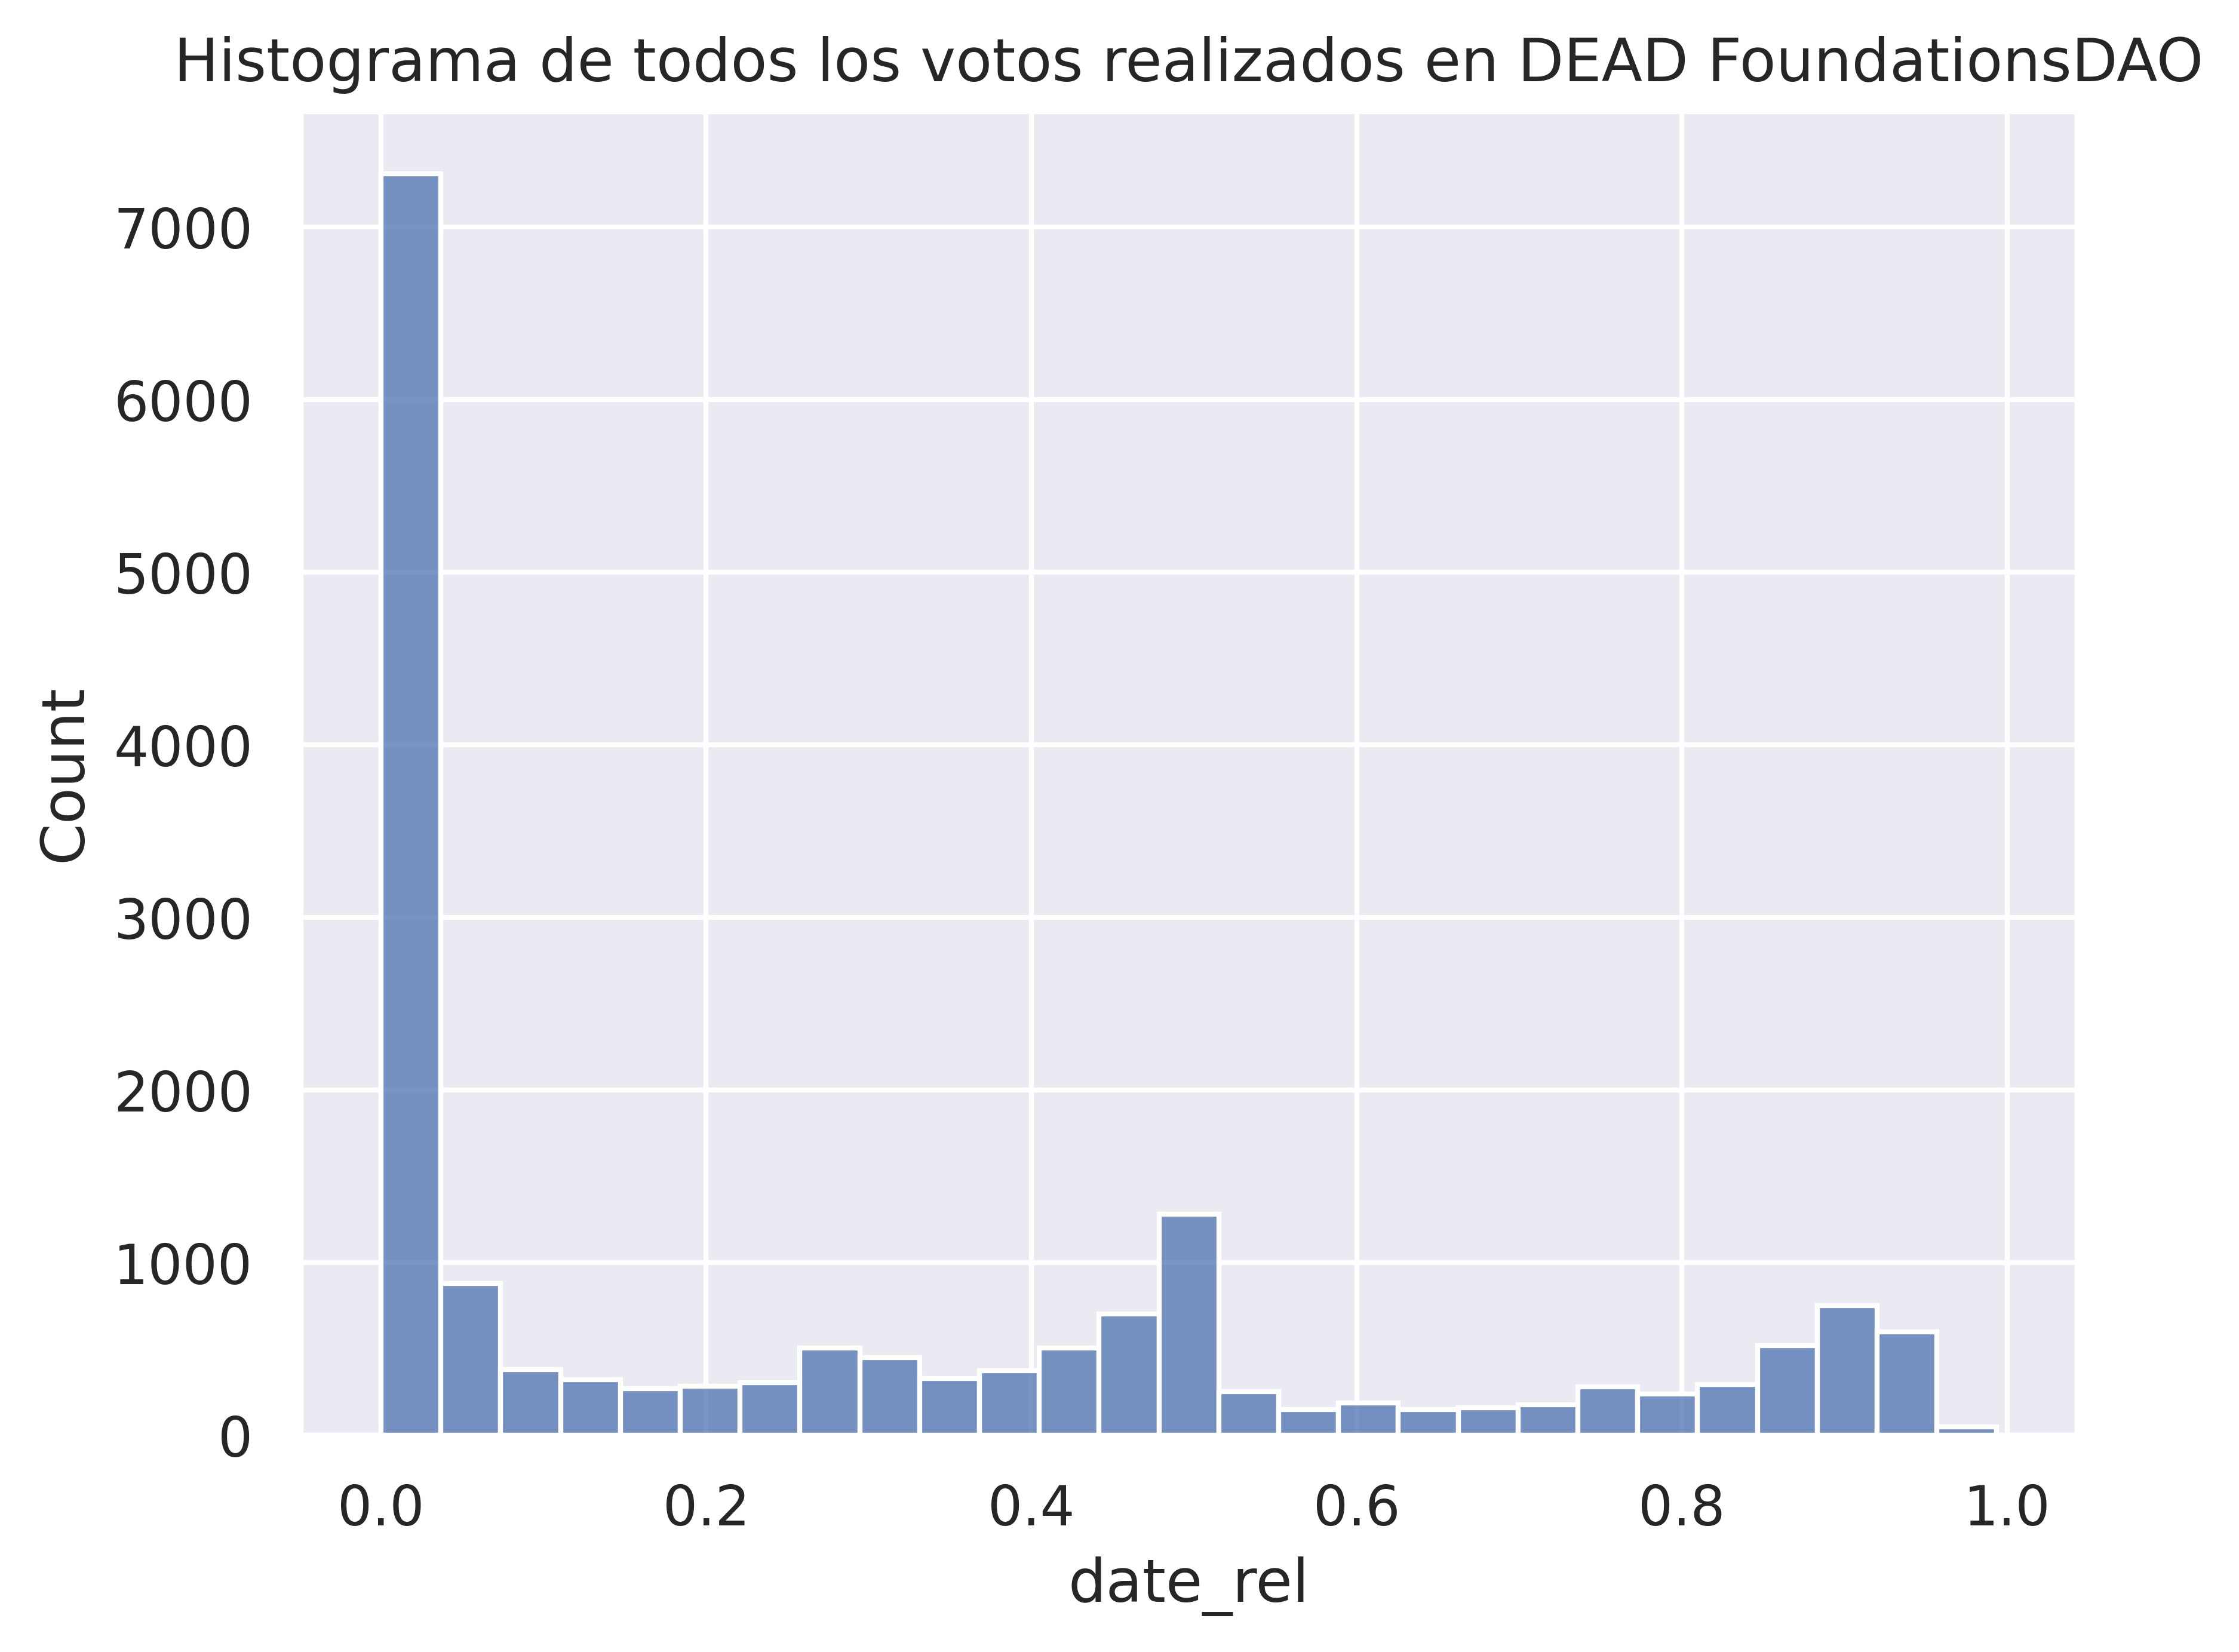

In [22]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [23]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

date_rel
count  17738.000000
mean       0.289520
std        0.319066
min        0.000069
10%        0.002177
25%        0.007215
50%        0.143844
75%        0.497009
78%        0.510490
80%        0.560192
max        0.993538

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [24]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

platform                 name                              proposal  \
1376   daohaus  DEAD FoundationsDAO  9b0951e8-192b-5b68-8e1a-1b392e5b704f   
1377   daohaus  DEAD FoundationsDAO  9903573c-d495-5c45-8209-c16ac4527667   
12696  daohaus  DEAD FoundationsDAO  83846b14-c310-5c84-a229-f8f88747a417   
1381   daohaus  DEAD FoundationsDAO  83846b14-c310-5c84-a229-f8f88747a417   
12699  daohaus  DEAD FoundationsDAO  e5b05bac-ebea-5d63-b09c-6721cb6c3b65   
...        ...                  ...                                   ...   
11836  daohaus  DEAD FoundationsDAO  0d403a5d-a7ff-50ae-b3e9-7ab8020241eb   
11835  daohaus  DEAD FoundationsDAO  992cb72b-046d-55d8-81d0-f1e3f664c86a   
11830  daohaus  DEAD FoundationsDAO  6c40609b-866f-588e-947f-ae832a9e9af2   
11846  daohaus  DEAD FoundationsDAO  f4a42b8c-ee15-551f-8e65-86b17a237863   
12165  daohaus  DEAD FoundationsDAO  2abb72d8-410a-5ad6-9ceb-e2d6926eabc9   

                     date               start                 end  date_rel  \
1376  2020-11-25 14:31:40 2020-11-25 13:05:15 2020-11-27 16:35:40  0.027963   
1377  2020-11-25 14:34:40 2020-11-25 14:32:45 2020-11-27 16:36:55  0.000638   
12696 2020-12-04 01:16:40 2020-12-04 01:12:45 2020-12-06 19:33:50  0.000984   
1381  2020-12-04 01:41:40 2020-12-04 01:12:45 2020-12-06 19:33:50  0.007264   
12699 2020-12-05 00:14:50 2020-12-05 00:05:45 2020-12-07 15:23:20  0.002392   
...                   ...                 ...                 ...       ...   
11836 2022-06-28 08:18:00 2021-11-19 18:43:40 2022-09-25 19:25:10  0.711436   
11835 2022-06-28 08:18:15 2021-11-19 17:26:27 2022-09-25 19:26:15  0.711484   
11830 2022-06-28 08:18:30 2021-11-19 14:39:10 2022-09-25 19:27:30  0.711591   
11846 2022-06-28 08:19:45 2021-11-20 09:30:50 2022-09-25 19:28:45  0.710859   
12165 2022-07-26 17:09:25 2022-07-26 17:01:45 2022-09-25 19:33:40  0.000087   

       freq  cumfreq  
1376    1.0      1.0  
1377    1.0      1.0  
12696   0.5      0.5  
1381    0.5      1.0  
12699   0.5      0.5  
...     ...      ...  
11836   1.0      1.0  
11835   1.0      1.0  
11830   1.0      1.0  
11846   1.0      1.0  
12165   1.0      1.0  

[17738 rows x 9 columns]

In [25]:
_dfv2.groupby('proposal').size().sort_values()

proposal
9b0951e8-192b-5b68-8e1a-1b392e5b704f      1
a3ac8c7d-7620-5838-8333-7ac20097fe48      1
8427196e-115d-52e4-abcb-9275f780febb      1
509794be-65fa-50f2-8a2a-4491c17c8c9a      1
aa2fa966-f38a-5b7e-8d56-73215b701e89      1
                                       ... 
bbda5662-de3b-5674-948f-bbf5caecde0a    103
ee40c9f7-e5ca-511d-be94-60378c4d2978    108
e828e138-90dd-5939-8572-91fa75d97d9f    118
ff084a60-6d34-5168-8e98-e6ff05912de5    120
e1741bfb-7d15-5942-92f8-313e1942d846    120
Length: 5591, dtype: int64


### KDE plot de las más votadas

/tmp/ipykernel_181589/2348142249.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")
/tmp/ipykernel_181589/2348142249.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")


Text(0.5, 1.0, 'kde plot de las 15 propuestas más grandes en DEAD FoundationsDAO')

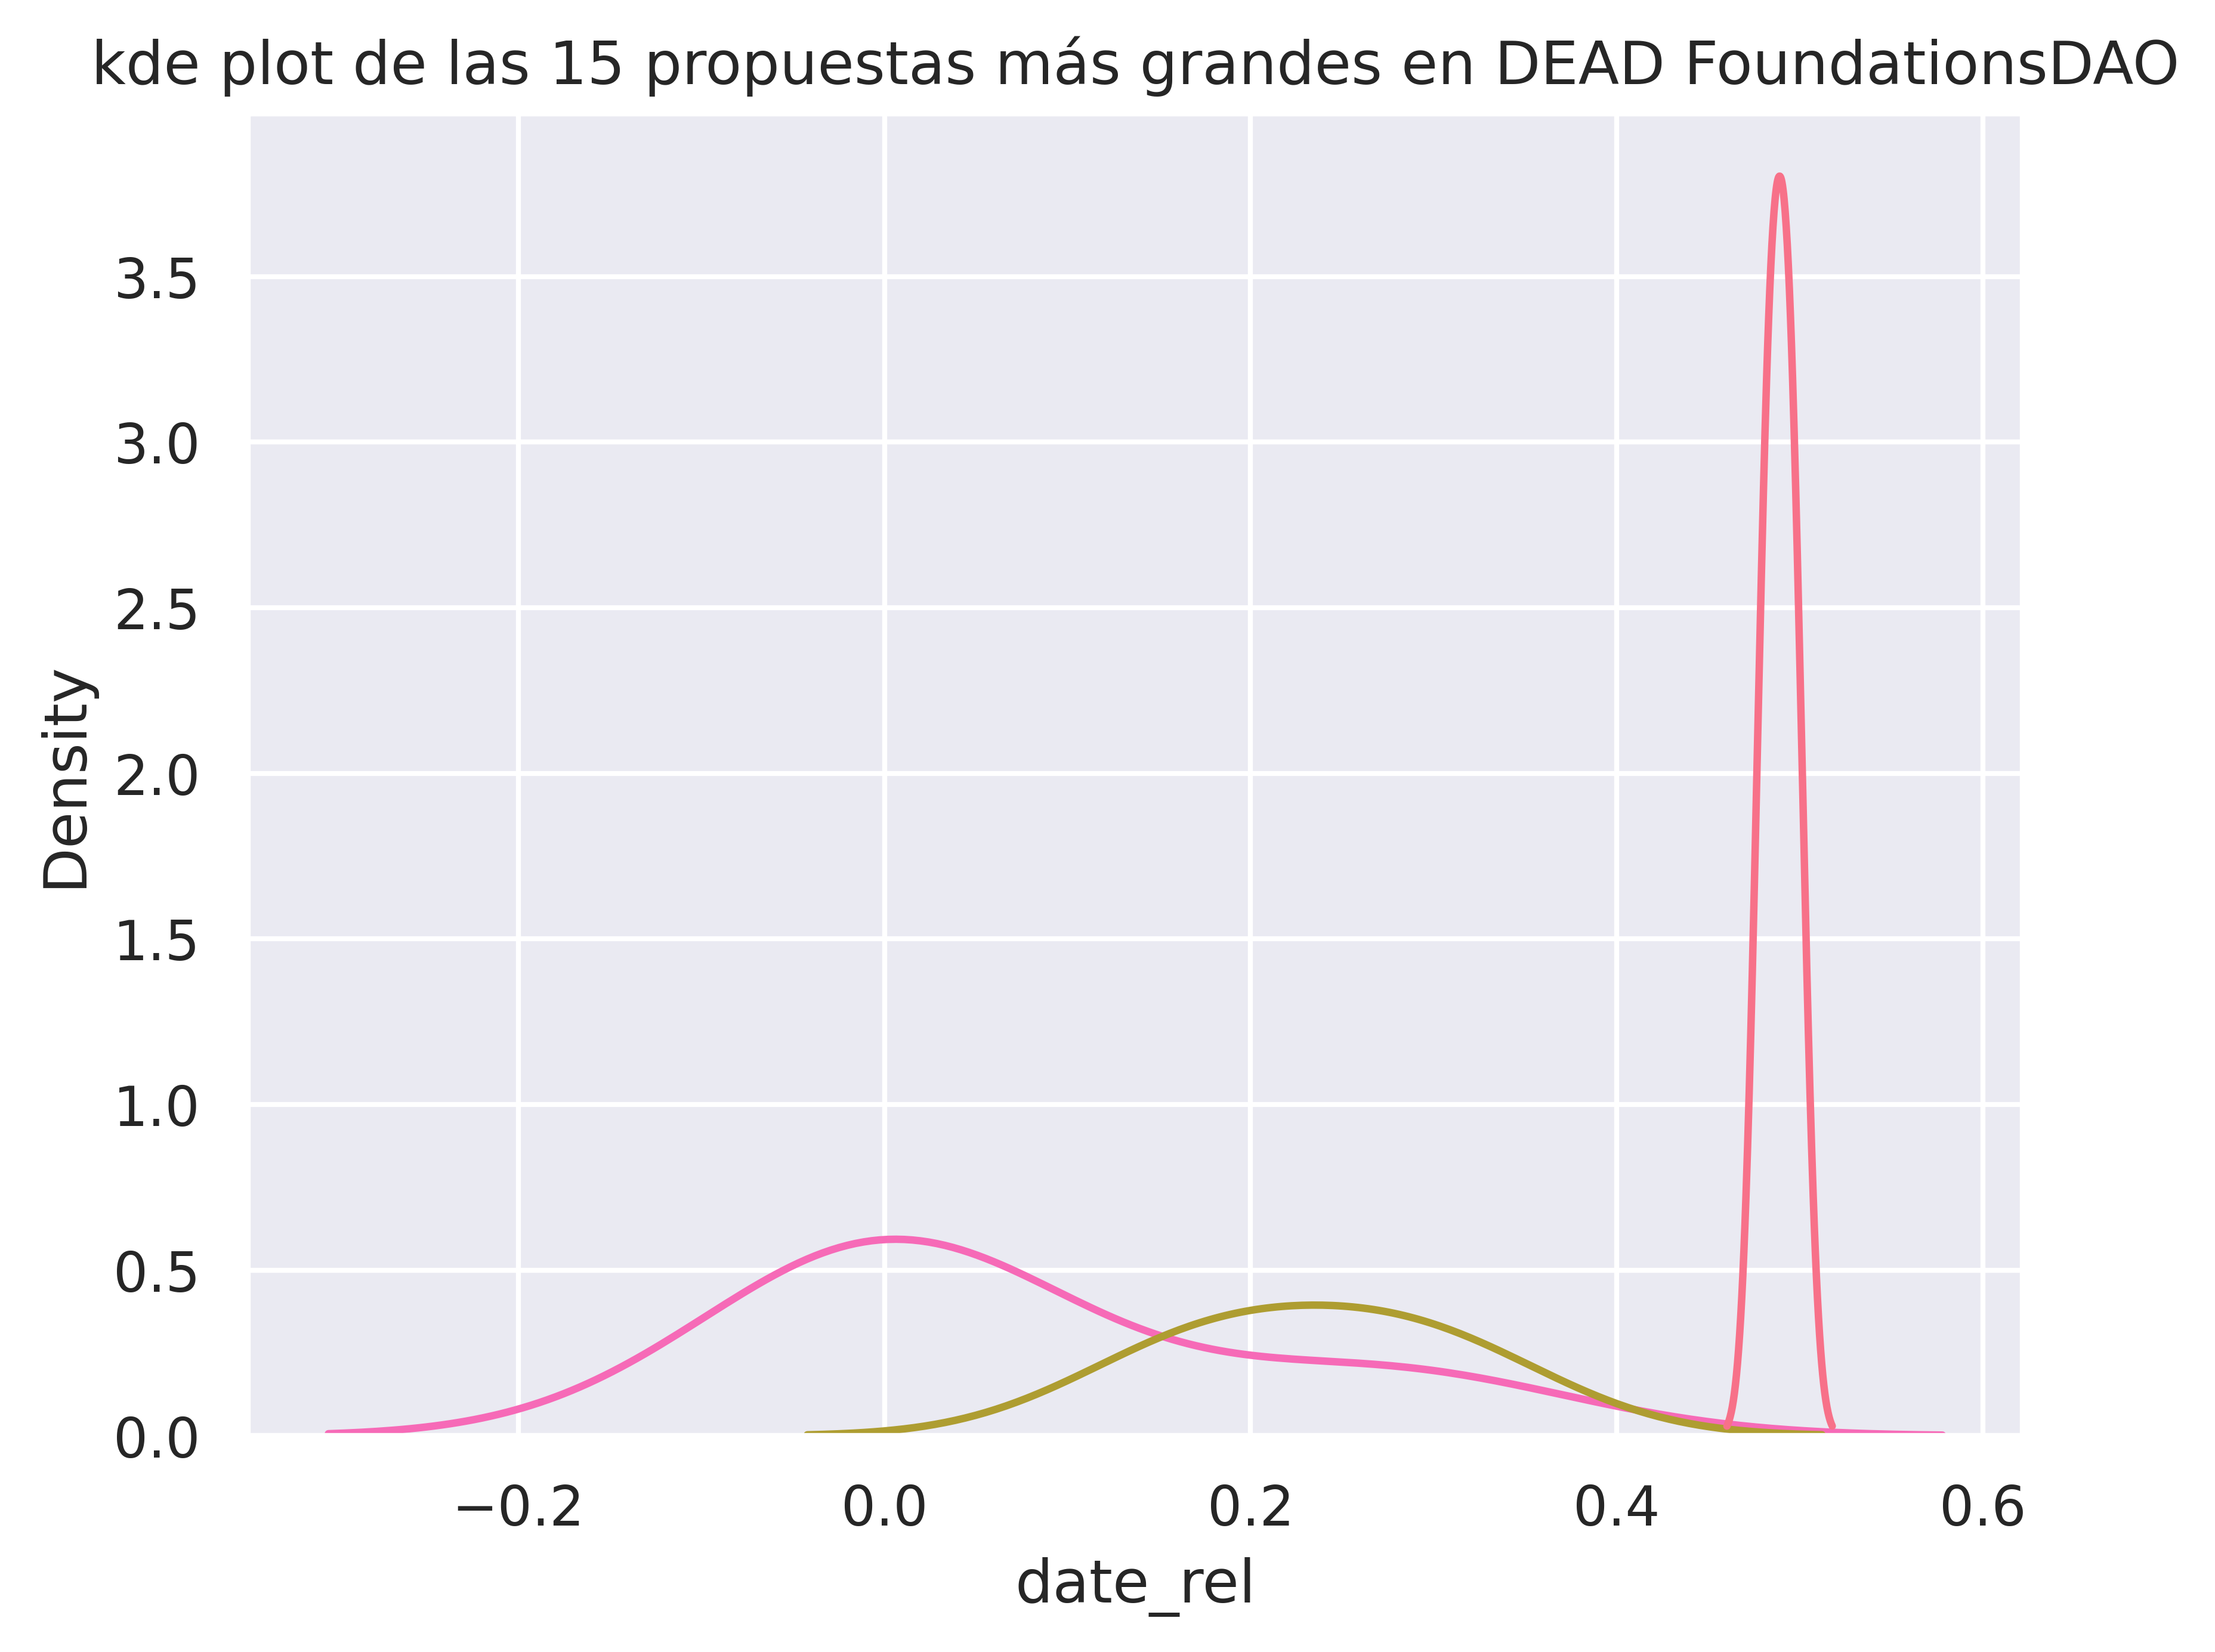

In [26]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.